# base_v3.ipynb

Version of base_v3 using gated_bp_rga synapses on the M__C connections.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
##################################
####### Create the network #######
##################################

# simulation control parameters
t_pres = 25. # number of seconds to hold each set of target lengths
rand_w = False # whether to use random weights in M->C, AF->M

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.4,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 1.,
          'mu2': 1.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : 20.,
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 8.,  #8
          'k_se_e' : 20., #13
          'b_e' : 5.,
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]
#unrelated = set(all_pairs) - set(antagonists) - set(part_antag) - set(synergists) - set(part_syne) - set(self_conn)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.001 # range of heterogeneity as a fraction of the original value
#randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

ACT_params = {'type' : unit_types.act,
              'tau_u' : 8.,
              'gamma' : 2.,
              'g' : 2.,
              'theta' : 1.,
              'tau_slow' : 5.,
              'y_min' : 0.2,
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

AF_params = {'type' : unit_types.chwr_linear, #logarithmic,
             'init_val' : [0.05, 0.05, 0.07, 0.06, 0.06, 0.06, # avg afferent values
                           0.09, 0.06, 0.19, 0.10, 0.14, 0.07,
                           0.25, 0.16, 0.36, 0.29, 0.27, 0.19]*2,
             'tau' : 0.02 * randz36(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 400., # using a slow value, so init_val is important
             'delay' : 0.1,
             'thresh' : -.1 }
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.2 * randz6(),
             'slope' : 2.5 * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.05 * randz6() }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0. * randz6(),
             'slope' : 1.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 20.,
             'custom_inp_del' : 15,
             'integ_amp' : 0.1, #.5,
             'integ_decay' : 0.01,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.5 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 20.,
             'custom_inp_del' : 15,
             'integ_amp' : 0., #.5,
             'integ_decay' : 0.05,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz12(),
            'slope' : 3. * randz12(),
            'init_val' : 0.2 * randz12(),
            'delay' : 0.2,
            'tau_fast': 0.1,
            'tau_mid': 1.,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz12(),
            'p0_inp' : 0.0,
            'des_out_w_abs_sum' : 3. }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.1+np.array([0.02, 0.03, 0.01, 0.01, 0.03, 0.03,
                                  0.03, 0.05, 0.01, 0.00, 0.04, 0.04]),
             'slope' : 1.5*np.array([10.37, 7.83, 9.47, 10.4, 8.70, 8.70,
                                 9.31, 6.61, 8.56, 10.7, 7.41, 8.07]),
             'init_val' : 0.2 * randz12(),
             'tau' : 0.03 * randz12() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.4 * randz12(),
              'slope' : 6. * randz12(),
              'init_val' : 0.3 * randz12(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz12() }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ACT to CE,CI ------------------------------------------------
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# AF to CE, CI --------------------------------------------------
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 2.,
              'lrate' : 10.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 2.,
              'lrate' : 10.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
# AF to M ------------------------------------------------
## Creating a test matrix
if not rand_w:
    # Initializing weights using correlations between 36 AF units and 12 M units
    AF_M = np.array(
        [[-3.05803830e-01,-9.34330320e-02,-1.21172303e-01,2.45893899e-01,
          -4.20333566e-01,1.57326764e-01,3.03208393e-01,9.83833568e-01,
          -4.21342534e-01,-2.08482912e-01,1.60660359e-01,1.47322119e-04,
          3.12100299e-01,6.14540800e-01,-1.92725404e-01,-1.96793297e-01,
          2.82486901e-01,-2.33714894e-01,1.26554795e-01,1.15429798e-01,
          9.42604627e-02,-1.20367303e-01,3.30791862e-01,-8.66222557e-02,
          -2.53382806e-01,-4.18711972e-01,9.94299631e-01,2.49171082e-01,
          -6.57588866e-02,1.11397235e-01,-1.96039638e-01,-1.88407634e-01,
          6.10874112e-01,2.81384053e-01,-2.48823516e-01,2.53738655e-01]
        ,
        [-1.03792929e-01,7.54643579e-02,3.21217158e-01,2.66999620e-01,
         -8.12210671e-02,-1.76877866e-02,1.76909228e-01,1.34269792e+00,
         -5.26406481e-01,-1.08602212e-01,-4.02409375e-01,3.48077619e-01,
         2.42549196e-01,5.75686044e-01,-1.55594976e-01,-1.46494637e-01,
         1.82491878e-01,-1.22135696e-01,4.01234467e-02,-5.01843130e-02,
         -1.64429238e-01,-7.55795069e-02,3.87443394e-02,1.55505738e-01,
         -1.38303245e-01,-4.91240277e-01,1.32214595e+00,1.44063379e-01,
         3.46148742e-01,-4.22885476e-01,-1.52736448e-01,-1.61052993e-01,
         5.79991162e-01,2.21126428e-01,-1.35498565e-01,1.64073851e-01]
        ,
        [ 1.78562931e-01,3.44605615e-01,-3.21062385e-01,9.59602964e-02,
         3.36226700e-01,1.12596896e-01,-8.52591697e-02,-7.30416661e-01,
         5.87344792e-01,5.19634225e-02,2.98133255e-01,-3.46627547e-01,
         -1.54976263e-01,-3.70783822e-01,2.63005911e-01,1.17197673e-01,
         -8.18331146e-02,7.39216984e-02,-3.75697312e-01,-3.83830328e-01,
         1.49693479e-01,-4.90066333e-01,-4.60433740e-01,-4.59953830e-01,
         8.35742648e-02,6.04395665e-01,-6.90990591e-01,-5.34975869e-02,
         -3.60604874e-01,3.07305564e-01,1.34180436e-01,2.62443607e-01,
         -3.54186953e-01,-1.33419460e-01,7.85716311e-02,-7.69519098e-02]
        ,
        [ 1.92227937e-01,1.05807824e-01,-8.16125377e-02,-3.86989732e-02,
         3.23183795e-01,-1.58337349e-01,-2.96634720e-01,-6.33479321e-01,
         3.34921372e-01,2.49228244e-01,-3.34107641e-01,2.49182338e-01,
         -2.93974023e-01,-4.72732318e-01,3.13720324e-01,2.58647899e-01,
         -3.03192695e-01,3.16916723e-01,-1.95541613e-01,-2.01347712e-01,
         7.27571734e-02,2.38228406e-02,-3.33010727e-01,2.01979076e-01,
         2.97436834e-01,3.17702940e-01,-6.18318467e-01,-2.50492870e-01,
         3.03333981e-01,-3.22697805e-01,2.87881063e-01,3.00345930e-01,
         -4.48542673e-01,-2.59353586e-01,3.27588606e-01,-2.81117406e-01]
        ,
        [-2.14142304e-01,6.68965753e-02,-8.31170442e-02,-8.13862111e-02,
         -3.46693205e-01,2.25889632e-01,1.93164420e-01,-5.45110165e-01,
         2.14761095e-01,-1.63141787e-01,9.51202006e-01,-6.62808412e-01,
         1.54841901e-01,-1.33084626e-01,-1.24449228e-01,-1.36503689e-01,
         4.04721716e-01,-3.45695731e-01,1.40876678e-03,-1.35054875e-01,
         7.45574339e-02,-1.91817330e-01,1.15528439e-01,-4.45491405e-01,
         -1.94856150e-01,2.35872635e-01,-5.39424660e-01,1.57781312e-01,
         -7.19290755e-01,8.62438147e-01,-1.65401776e-01,-1.14209540e-01,
         -1.47626378e-01,1.22052430e-01,-3.68632193e-01,3.61194588e-01]
        ,
        [-1.18376161e-01,2.97225030e-02,7.76643151e-01,-1.79298220e-01,
         -1.06594122e-01,-3.18489830e-01,3.93773729e-02,1.05239433e+00,
         -4.88323781e-01,4.19878315e-03,-4.78528604e-01,7.02595948e-01,
         9.92929426e-02,3.54919647e-01,-1.98868661e-01,-8.19102592e-02,
         5.14955923e-03,4.00058813e-02,1.43879623e-01,-2.73973076e-02,
         -4.30565243e-01,2.61493680e-01,7.46475350e-02,4.62436576e-01,
         -4.00475936e-02,-4.95524726e-01,9.77318236e-01,-4.68043181e-03,
         7.17645631e-01,-5.25940200e-01,-1.00084863e-01,-2.08448750e-01,
         3.42865918e-01,8.10847354e-02,3.53832534e-02,1.85591750e-03]
        ,
        [-1.39794796e-01,1.56316387e-01,-3.20816220e-01,3.03716655e-01
        ,-2.69576748e-01,1.43263970e-01,2.45333807e-01,4.99564521e-01
        ,-3.77210835e-01,-1.67139490e-01,2.44186778e-01,-1.68302002e-01
        ,3.65344360e-01,6.80170307e-01,-2.79807172e-01,-2.22196757e-01
        ,3.64541490e-01,-2.35755427e-01,3.56637466e-02,-1.63991246e-01
        ,4.16374889e-01,-1.58293168e-01,2.45021769e-01,-9.25446761e-02
        ,-2.17168451e-01,-4.09825639e-01,4.95671677e-01,1.87333672e-01
        ,-1.90523570e-01,1.57496482e-01,-2.23560096e-01,-2.81218051e-01
        ,6.64257512e-01,3.14166360e-01,-2.57336183e-01,3.06521148e-01]
        ,
        [ 1.29857292e-01,1.41430277e-01,-2.85522518e-01,4.68485844e-01
        ,5.56524333e-02,1.24593805e-01,1.92274549e-01,1.13366116e+00
        ,-4.31085387e-01,-1.49474793e-01,-2.87338820e-01,2.02890723e-01
        ,3.12622613e-01,9.39677977e-01,-1.97942332e-01,-2.06141289e-01
        ,8.68320926e-02,-1.27053745e-02,-1.50846026e-01,-1.35126559e-02
        ,2.23966301e-01,-1.47529056e-01,-1.67291441e-02,1.52203543e-02
        ,-1.69810530e-01,-4.36541615e-01,1.14165397e+00,1.68157497e-01
        ,1.82318921e-01,-2.81275297e-01,-2.02111513e-01,-1.91716354e-01
        ,9.37846231e-01,2.84490034e-01,-1.62405862e-02,6.18521198e-02]
        ,
        [ 2.85737081e-01,9.76176606e-02,-4.55299692e-03,2.45530305e-01
        ,3.69753621e-01,2.54244793e-01,-1.25578999e-01,-6.85465218e-01
        ,3.25028512e-01,7.89016852e-02,4.08843056e-02,-2.28365915e-01
        ,-2.49255787e-01,-6.37335943e-01,5.17823928e-01,2.07494315e-01
        ,-9.35942874e-02,9.06218858e-02,-3.70959972e-01,-8.27143532e-02
        ,-2.36725248e-01,-4.97260778e-01,-4.49072080e-01,-5.96865281e-01
        ,1.25665418e-01,3.45291620e-01,-6.22893164e-01,-7.88918516e-02
        ,-2.23133470e-01,8.12934284e-02,2.45998203e-01,5.42934690e-01
        ,-5.85617286e-01,-2.05787801e-01,9.05516761e-02,-8.56054173e-02]
        ,
        [-8.21750183e-03,3.31703376e-02,-6.36892474e-02,9.17097098e-02
        ,5.20453295e-02,1.19005023e-01,-2.10268360e-01,-9.17470461e-01
        ,3.97829033e-01,1.69911158e-01,4.22952217e-03,-1.00458495e-01
        ,-3.80484875e-01,-7.56943866e-01,4.77163076e-01,3.35760423e-01
        ,-2.88882519e-01,3.02982841e-01,-5.66145806e-02,-1.63879852e-01
        ,7.28215318e-02,-2.68781853e-01,-1.51223603e-01,-2.92391518e-01
        ,2.05850187e-01,3.94964157e-01,-8.86866209e-01,-1.73608885e-01
        ,-9.41176824e-02,3.74888716e-02,3.77181338e-01,4.74175313e-01
        ,-7.19594772e-01,-3.36209616e-01,3.14259859e-01,-2.71279543e-01]
        ,
        [ 3.73882452e-01,1.37580355e-01,2.23007147e-01,1.75756787e-01
        ,1.82703025e-01,1.71750079e-01,2.33279264e-01,2.29128997e-02
        ,-1.57865173e-01,-1.73607135e-01,5.22047019e-01,-4.96670284e-01
        ,3.55400892e-01,2.19242996e-01,-2.53999864e-01,-2.77115123e-01
        ,6.46373441e-01,-5.14054606e-01,-2.11617465e-01,-4.86644227e-02
        ,-1.38783632e-01,-2.78147405e-01,-6.33920462e-02,-3.75315948e-01
        ,-2.25610292e-01,-1.39337586e-01,2.24581051e-02,1.77868318e-01
        ,-5.39659403e-01,4.50712291e-01,-3.18565611e-01,-2.35985816e-01
        ,2.02645546e-01,2.96390474e-01,-5.59582300e-01,5.78020077e-01]
        ,
        [ 2.54689153e-01,3.40742636e-01,2.02166896e-03,9.92310169e-02
        ,2.64571089e-01,-2.09334989e-02,-2.32734902e-01,-3.83546226e-01
        ,3.19665653e-01,1.90788180e-01,-3.08894345e-01,3.79348560e-01
        ,-3.16230385e-01,-1.90145565e-01,2.12571060e-01,2.73425571e-01
        ,-4.51356415e-01,6.55600132e-01,-2.78814519e-01,-3.92405529e-01
        ,1.15516251e-01,-6.64398094e-02,-3.69320574e-01,7.02417720e-02
        ,1.97509473e-01,2.98488945e-01,-3.90079783e-01,-2.18634846e-01
        ,3.63081665e-01,-2.67063982e-01,2.75135695e-01,2.04290208e-01
        ,-1.77848487e-01,-3.03675406e-01,6.61959426e-01,-4.52842331e-01]]).transpose()
else:
    #AF_M = 0.2*(np.random.random((12,12)) - 0.5) # random initial connections!!!!!
    AF_M = 0.2*(np.random.random((12,36)) - 0.5) # random initial connections!!!!!
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_diff_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'normalize' : True,
            'w_sum' : 10.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 10., #20.,
            'extra_steps' : None, # placeholder value; filled below,
            'init_w' : AF_M.flatten() }
# AF to SF ------------------------------------------------
AF__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AF__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# AL to P ------------------------------------------------
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI  ------------------------------------------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'init_w' : 1. }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -2. }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : 1., #16.,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : .2, # 8.,
                  'lrate' : 1.,
                  'des_act' : 0.2 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.2 }
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0. }
C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                   'lrate' : 1.,
                   'init_w' : 0. }

# M to CE,CI ----------------------------------------------
# creating a test matrix
if not rand_w:
    # initializing from correlations, using a delay of 51*min_del
    M_CE = np.array(
        [[-0.02720695, -0.06017303, 0.00864209, 0.03440552, -0.01974181, 0.04408774],
         [-0.0170463, -0.06232294, -0.01221159, 0.04871612, -0.11048114, 0.06800671], 
         [ 0.41380948, -0.72516662, 0.13852317, 0.14592244, 0.10601134, 0.14126386], 
         [-0.14112191, -0.22893548, -0.18015029, 0.24090996, -0.16255895, 0.24571946], 
         [-0.00848826, -0.07826826, 0.01912161, 0.02934777, -0.01368699, 0.03831893], 
         [-0.58184048, -0.09256466, -0.61644532, 0.54705909, -0.72520614, 0.58682024], 
         [-0.02362442, -0.06805692, 0.00865622, 0.03665817, -0.01859812, 0.04631143], 
         [-0.0233469, -0.06971773, -0.00184501, 0.04481675, -0.04883805, 0.05680935], 
         [ 0.36710761, -0.21408296, 0.1981183, -0.04543007, 0.15676157, -0.0742685 ], 
         [-0.37820531, -0.41562294, -0.48588325, 0.53958204, -0.38604416, 0.50866357], 
         [-0.01647623, -0.0643555, 0.01894523, 0.02773385, -0.00301092, 0.0359857 ], 
         [-0.43591654, -0.40904151, -0.5403631, 0.5653697, -0.49727727, 0.54438041]]).transpose()
    M_CI = np.array(
        [[-0.03686006, -0.02641613, -0.03400054, -0.01850678, -0.04030588, 0.00322243], 
         [ 0.00701031, 0.02631613, 0.01965957, 0.03217951, 0.00287137, 0.09118943], 
         [-0.62304508, -0.72882814, -0.61076783, -0.67640659, -0.59678107, -0.82860307], 
         [-0.01250425, -0.04533643, 0.00591845, -0.01870595, -0.00332235, -0.0766605 ], 
         [-0.0515761, -0.04195229, -0.04861983, -0.03380842, -0.05475065, -0.01188934], 
         [ 0.52870693, 0.5031705,  0.57094147,  0.53373818,  0.53880749,  0.48017721], 
         [-0.04311299, -0.03384301, -0.03992518, -0.02547985, -0.0461681, -0.00509923], 
         [-0.02836567,  -0.01692589,  -0.02193666,  -0.00907285, -0.0314748, 0.021268 ], 
         [-0.4844158, -0.42591181, -0.42172237, -0.44467057, -0.48422557, -0.21670132], 
         [ 0.14264492, 0.03452057,  0.16765315,  0.09119384, 0.16716283, -0.14418413], 
         [-0.05345766, -0.04305903, -0.05069788, -0.03533652, -0.05679282, -0.01277889], 
         [ 0.25986967,  0.15666782, 0.29401394,  0.2160979, 0.28307591,  0.01060964]]).transpose()
    
    # Using a delay of 12*min_del for the correlation
#     M_CE = np.array(
#         [[1.16019556e-02, 1.65509472e-02, -1.75030330e-02, -1.78708256e-02, 1.08690037e-02, -1.07374434e-03],
#          [ 5.20752455e-01, 5.27148961e-01, -5.30798633e-01, -5.29957808e-01, 5.20421193e-01, -5.02889649e-01], 
#          [-3.42285352e-03, 1.27272441e-02, 3.09942778e-03, 8.54705635e-03, 1.00115999e-02, -3.76404188e-02], 
#          [ 1.09578752e-02, 6.56737349e-04, -2.94250598e-03, -4.65448355e-03, 6.60486571e-03, -1.14274538e-02], 
#          [-4.87107489e-01, -4.78284133e-01, 4.73621471e-01, 4.70603464e-01, -4.91486970e-01, 5.19198880e-01], 
#          [ 1.87804165e-02, 4.79317107e-03, -8.86430502e-03, -1.24243793e-02, 1.19259841e-02, -1.39262196e-02], 
#          [ 2.87867182e-02, 2.61989815e-02, -3.15439701e-02, -3.03922057e-02, 2.87992084e-02, -2.13091590e-02], 
#          [ 4.23199875e-01, 4.19868010e-01, -4.25326672e-01, -4.27141048e-01, 4.19764527e-01, -4.06407618e-01], 
#          [-1.85975179e-03, 2.06732982e-02, 2.04038035e-04, 6.93603938e-03, 1.57993391e-02, -4.98082520e-02], 
#          [ 1.06360368e-02, 2.51787618e-04, -2.48217734e-03, -4.61778506e-03, 5.95682235e-03, -1.02658656e-02], 
#          [-5.57019630e-01, -5.61582595e-01, 5.58021963e-01, 5.59744281e-01, -5.56387715e-01, 5.54286467e-01], 
#          [ 2.46943926e-02, 1.09975906e-02, -1.54856033e-02, -1.87723051e-02, 1.77221417e-02, -1.87369672e-02]])
#     M_CI = np.array(
#         [[ 0.14603643, -0.23475703, 0.00977237, -0.1509648, 0.19517338, -0.13147413], 
#          [-0.24549545, -0.18905471, 0.60949194, 0.28628226, -0.13011016, 0.3368039], 
#          [-0.14786403, 0.21067372, 0.06139718, 0.15664702, -0.17159494, 0.10922032], 
#          [-0.15980207, 0.22961695, 0.0487661, 0.16120329, -0.18406148, 0.12084049], 
#          [ 0.81787641, -0.77403265, -0.08519152, -0.78933944, 0.82540229, -0.84236013], 
#          [-0.16730105, 0.23261418, 0.09583993, 0.1720083, -0.19026144, 0.12129628], 
#          [ 0.12753787, -0.01626146, -0.58478528, -0.20319006, 0.1025622, -0.05938734], 
#          [-0.1519716, 0.07340394, 0.0938492, 0.11343896, -0.12697429, 0.18225674], 
#          [-0.15420739, 0.20335601, 0.08326953, 0.16464436, -0.17436254, 0.11794357], 
#          [-0.15545026, 0.2065313, 0.07545983, 0.16346471, -0.17594966, 0.12025537], 
#          [ 0.24864239, -0.1547106, -0.48610947, -0.23877551, 0.20965133, -0.19660659], 
#          [-0.15800126, 0.21262034, 0.07824019, 0.16458092, -0.1794747, 0.12121153]])
else:
    M_CE = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
    M_CI = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.gated_bp_rga,
             'inp_ports' : 0,
             'lrate' : 1.,
             'w_sum' : 3.,
             'w_thresh' : 0.05,
             'w_decay': 0.005,
             'w_tau' : 60.,
             'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.gated_bp_rga,
             'inp_ports' : 0,
             'lrate' : 1.,
             'w_sum' : 3.,
             'w_thresh' : 0.05,
             'w_tau' : 60.,
             'w_decay': 0.005,
             'init_w' : M_CI.flatten() }
# P to AF  ---------------------------------------------------
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
Pe__AF_syn = {'type' : synapse_types.static,
              'init_w' : [1.]*18 } 
Pi__AF_syn = {'type' : synapse_types.static,
            'init_w' :  [-1.]*18 }
# SF, SP to SPF ------------------------------------------------
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI ------------------------------------------------
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M ------------------------------------------------
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M  ------------------------------------------------
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 2. }

#*************************************************************
# Setting the right delay for AF-->M
f = 1. # going to estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AF__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + (
                     net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1))
AF__M_syn['extra_steps'] = steps
#*************************************************************
# utilitiy function for the M-->C delays used in the rga rule
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.
        
        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps
# Approximating the delays for the rga rule
time_del, del_steps = approx_del(0.2) #0.65 was approximate CE/CI frequency observed in simulations
CE_params['delay'] = time_del
CI_params['delay'] = time_del
M_params['delay'] = time_del
CE_params['custom_inp_del'] = del_steps
CI_params['custom_inp_del'] = del_steps
#*************************************************************

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ACT = net.create(1, ACT_params)
AF = net.create(36, AF_params)
AL = net.create(6, AL_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
SF = net.create(12, SF_params)
SP = net.create(12, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.45], 
               [0.35, 0.4],
               [0.4, 0.35],
               [0.35, 0.3],
               [0.3, 0.25],
               [0.25, 0.3],
               [0.2, 0.35],
               [0.25, 0.4]]
               #[-0.1, 0.3],
               #[-0.1, 0.35]] # experimental extra coordinates
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia, II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE POSITIVE Ia AND II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the chwr_linear afferent units
Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
# time averages
Ia_II_avgs = np.array([0.09, 0.06, 0.19, 0.10, 0.14, 0.07, 0.25, 0.16, 0.36, 0.29, 0.27, 0.19])
# target averages
AF_thr = np.array([net.units[u].thresh for u in AF[6:18]])
#AF_Ia = np.maximum((Ia_ss - AF_avgs[0:6])*Pe__AF_Ia_ws - AF_thr[0:6], 0.)
#AF_II = np.maximum((II_ss - AF_avgs[6:12])*Pe__AF_II_ws - AF_thr[6:12], 0.)
AF_Ia_II = np.maximum((Ia_II_ss - Ia_II_avgs)*Pe__AF_ws - AF_thr, 0.)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from AF to SF
SF_arg = AF__SF_syn['init_w']*AF_Ia_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    #m_idxs[0] = 0 # for testing
AF_us = [net.units[u] for u in AF]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, AF__SF_syn['init_w'] * (
                    max(Ia_II_ss[cur_target(t)][idx] * Pe__AF_ws[idx] - 
                    net.units[AF[6+idx]].lpf_slow_sc_inp_sum - 
                    net.units[AF[6+idx]].thresh, 0.)))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track the weights from AF to M0

xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of CE0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
spj_track = net.create(1, track_params) # input derivative for MX--CE0

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF[0:18], P__AF_conn, Pe__AF_syn)
net.set_plant_outputs(P, AF[18:36], P__AF_conn, Pi__AF_syn)
# from AF to SF. Only positive Ia and II are selected
net.connect(AF[6:18], SF, AF__SF_conn, AF__SF_syn)
# from AF to M
## When connecting from all afferents:
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
## When connecting only from tension afferents
#net.connect(AF[0:6]+AF[18:24], M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
#net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
#net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
net.connect(SF, SPF, SFe__SPF_conn, SFe__SPF_syn) # F-P
#net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn)  # P-F
net.connect(SP, SPF, SPi__SPF_conn, SPi__SPF_syn) # F-P
#net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)  # P-F
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after AF-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
# from CE to CI, and CI to CE
#net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
#net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
# agonists and antagonists
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
    else:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)

# EE_syn_dicts = [C__C_syn_syne, C__C_syn_p_syne,
#                 C__C_syn_null, C__C_syn_null, C__C_syn_null]
# EI_syn_dicts = [C__C_syn_antag, C__C_syn_p_antag, C__C_syn_null, C__C_syn_null, C__C_syn_null]
# EE_pair_lists = [synergists, part_syne] # order should match list above
# EI_pair_lists = [antagonists, part_antag] # order should match list above
# for pair_list, syn_dict in zip(EE_pair_lists, EE_syn_dicts):
#     firsts = [CE[p[0]] for p in pair_list]
#     seconds = [CE[p[1]] for p in pair_list]
#     net.connect(firsts, seconds, C__C_conn, syn_dict)
# for pair_list, syn_dict in zip(EI_pair_lists, EI_syn_dicts):
#     firsts = [CE[p[0]] for p in pair_list] + [CE[p[1]] for p in pair_list]
#     seconds = [CI[p[1]] for p in pair_list] + [CI[p[0]] for p in pair_list]
#     net.connect(firsts, seconds, C__C_conn, syn_dict)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(18): # 12 if using only tensions
    net.units[AF_M0_track[idx]].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
X = 0 # index of the M unit we'll monitor

net.units[xp_track[0]].set_function(lambda t: net.units[CE[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[CE[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[CE[0]].get_lpf_fast(po_de) - 
                                    net.units[CE[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[CE[0]].avg_inp_deriv_mp[0])
ds = net.syns[CE[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                     net.units[M[X]].get_lpf_mid(ds))
# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [5]:
for unit in CE:
    print([syn.corr_type for syn in net.syns[unit] if syn.preID in M])

[None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]


In [6]:
[syn.delW for syn in net.syns[CE[0]] if syn.preID in M]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
start_time = time.time()
times, data, plant_data  = net.flat_run(300.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Searching base parameters...
* TESTING `gated_diff_inp_sel` SYNAPSES IN AF__M CONNECTIONS.
* Reduced tau_slow from 500 to 400 in AF
* Changed tau_fast and tau_mid in AF. Currently 0.1 and 1.0 respectively
* Restored BCM C__C connections
* Set ACT_params['tau_u'] from 5 to 8
* Changed delay in M__C plasticity rule (e.g. time_del, del_steps = approx_del(0.2))
* Set k_pe_e=8 , k_se_e=13, because correlations were not very informative
* Changed tau_fast from 0.01 to 0.1, and tau_mid from 0.05 to 1.0 in CE,CI, and M, because the differentiation was too fast. Also, things seemed unstable, so I changed mu1 and mu2 from 0.01 to 0.1 in arm_params.
* Set weight normalization in AF__M, and set w_sum = 10.
* Removed AF__CE/I connections
* Reduced learning rate in M__C from 50 to 10.
* Changed k_se_e from 13 to 20
* Increased 'g_e' from 10 to 20.
* Commented out the weight normalization lines in the source code of the gated_rga synapse. Arm got stuck, so I removed that.
* Changed AL_params, moving 'thresh' from 0.3 to  0.2, and 'slope' from 2 to 2.5.

---
* Set non-random AF__M and M__C connections.
* Changed AF__M lrate from 20 to 10. Normalize is set to False.
* Increased viscous friction mu1, mu2 from 0.1 to 1
* Reduced amplitude of adaptation from 8 to 4 in CE, from 8 to 6 in CI. Restored below.
* Set static C__C antagonists connections with init_w=16 for antagonints, init_w=8 for partial antagonists. Arm got stuck, and I blame it on C having WTA dynamics, with either flexors or extensors winning.
* Set CI__CE weights from -1.5 to -2. Arm still stuck.
* Restored adaptation amplitudes of 8 in both CE and CI
* Restored AF__C feedback connections, changing w_sum from 0.3 to 2, and lrate from 5 to 10. Changed below.
* Set AF__M normalization to True, w_sum to 10.
* Increased w_sum in M__CE from 2 to 3.
* Changed slope of CI from 2 to 1.5, thresh from 0.5 to 0.6
---
* USING GATED_BP_RGA SYNAPSES AT M__C, w_thresh=0.05, w_decay=0.005
* Removed AF__C connections
* Set C connections following guidelines from W-C_test1. Namely:
 * CE_params['slope']=1.5, CE_params['thresh']=0, CE_params['integ_amp']=0.1, CE_params['integ_decay']=0.01 CE_params['adapt_amp']=8.
 * CI_params['slope']=2., CI_params['thresh']=0.5, CE_params['integ_amp']=0., CE_params['adapt_amp']=8.
 * CE__CI_syn['init_w']=1, CI__CE_syn['init_w']=-2
 * C__C_syn_antag['init_w']=1., static synapse; C__C_syn_p_antag['init_w']=0.2, static synapse.
 * C__C_syn_syne['init_w']=0.5, static synapse; C__C_syn_p_syne['init_w']=0.2, static synapse
 * M__CE_syn['w_sum']=3, M__CI_syn['w_sum']=3
 * M__params['des_out_w_abs_sum'] = 3.
* Using all-to-all connections in C in order to enhance the RGA rule.
* Using the new integral decay model. integ_amp=0., integ_decay=0.05.
* Changed lrate from 10 to 1 in M__CE and M__CI.
* Changed tau_slow in CE, CI in order to make adaptation last longer.
---
* Set C unit port connectivity so averages are within CE/CI populations.

[0.14462181 0.26916426 0.00788984 0.04353746 0.06453126 0.10575383
 0.19931855 0.22393872 0.00523121 0.02366782 0.05931593 0.11659926]
[0.13983219 0.23622619 0.00934845 0.05833176 0.06035072 0.10240328
 0.18891287 0.16804895 0.00647751 0.02007901 0.06567763 0.12174412]


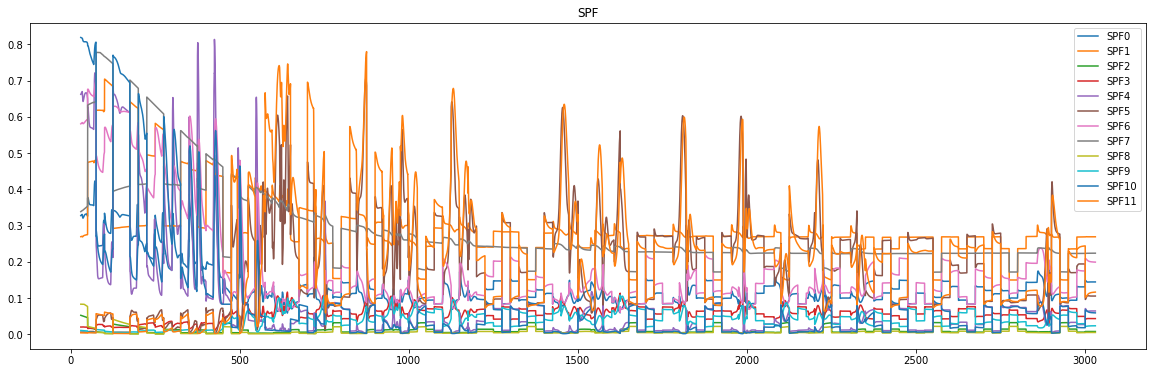

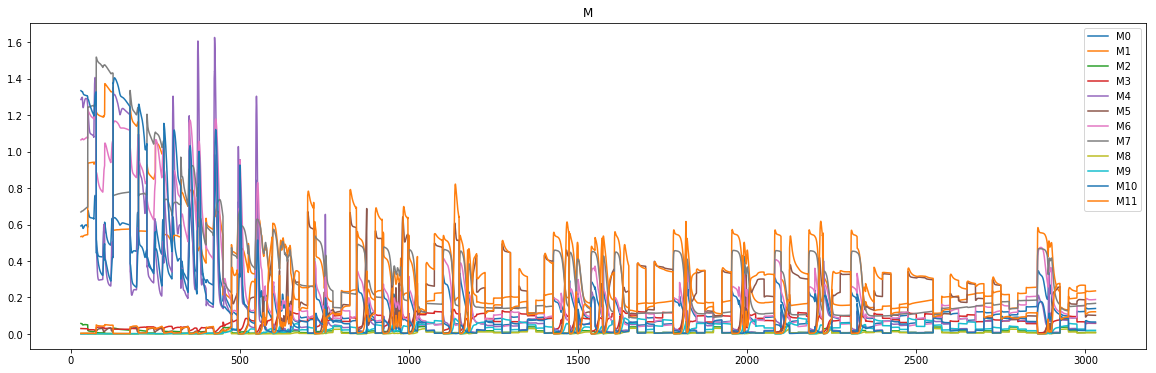

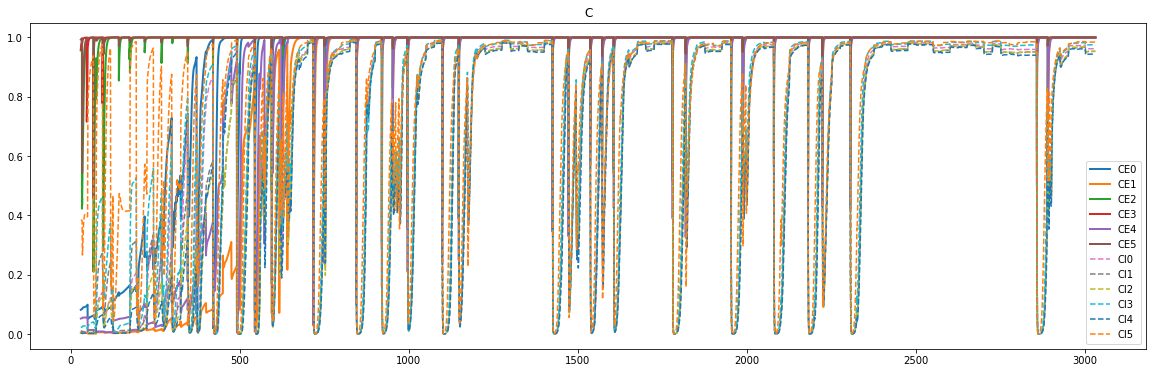

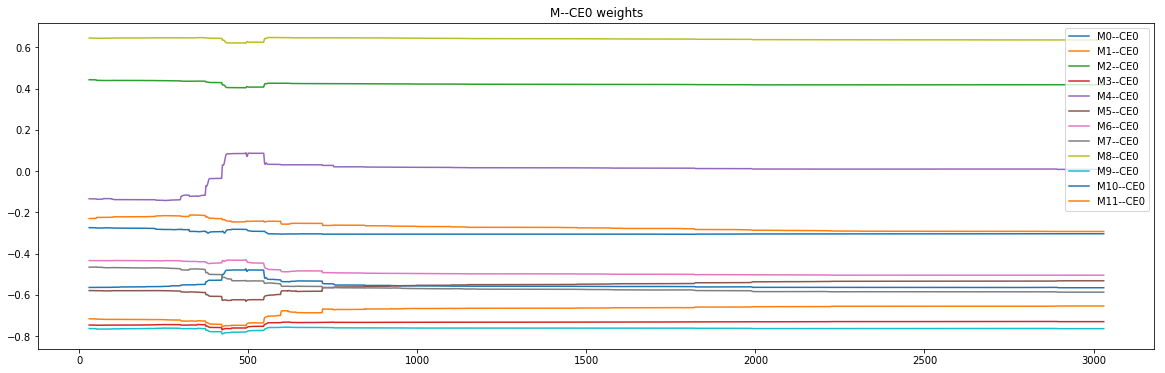

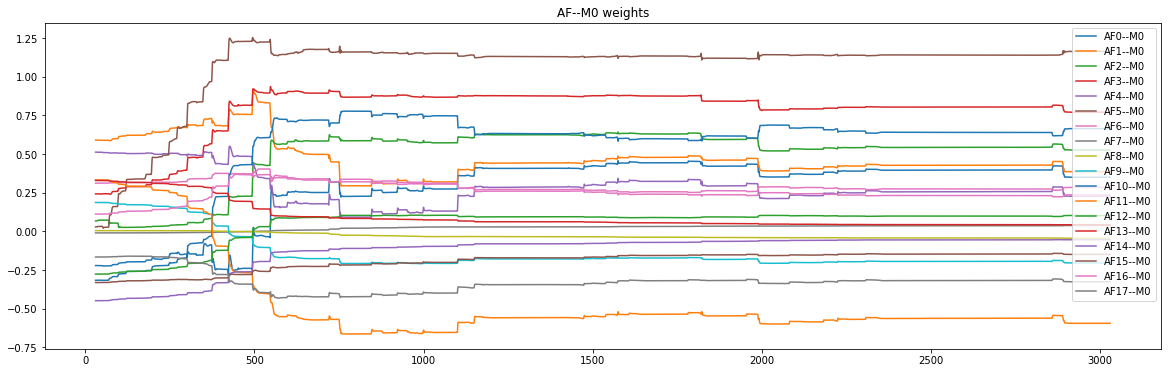

In [22]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights')

plt.show()

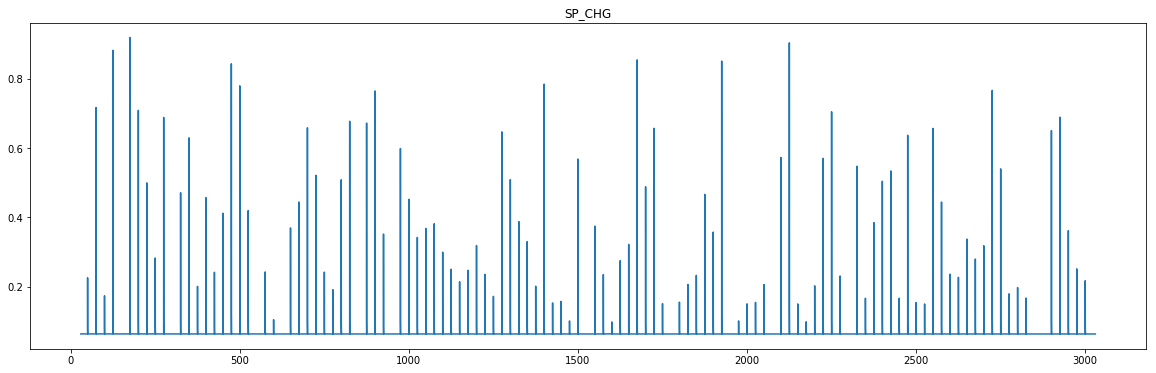

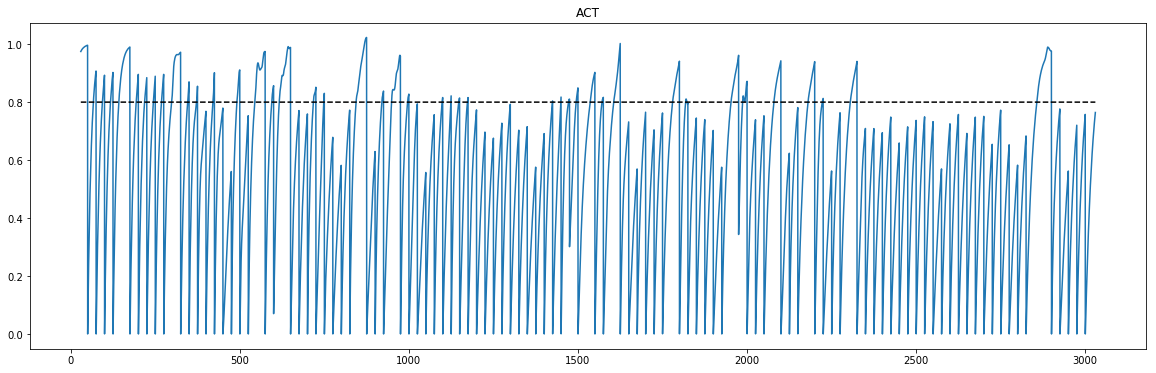

In [23]:
chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')

plt.title('ACT')
plt.show()

shoulder angle: -0.356560, shoulder vel: 1.764439
AFe_data:
[0.05621335 0.05727657 0.05647774 0.05507885 0.05873946 0.05807885
 0.09899358 0.09965452 0.10040452 0.10104491 0.0967646  0.10312183
 0.09804346 0.0994352  0.1006612  0.10201182 0.09500152 0.10480531]
AFi_data:
[0.14373521 0.14267198 0.14345024 0.14485942 0.14119881 0.14185942
 0.10091383 0.10028375 0.0994     0.09885221 0.10309136 0.09680615
 0.10169934 0.10040018 0.09896842 0.09768981 0.10472069 0.09499921]


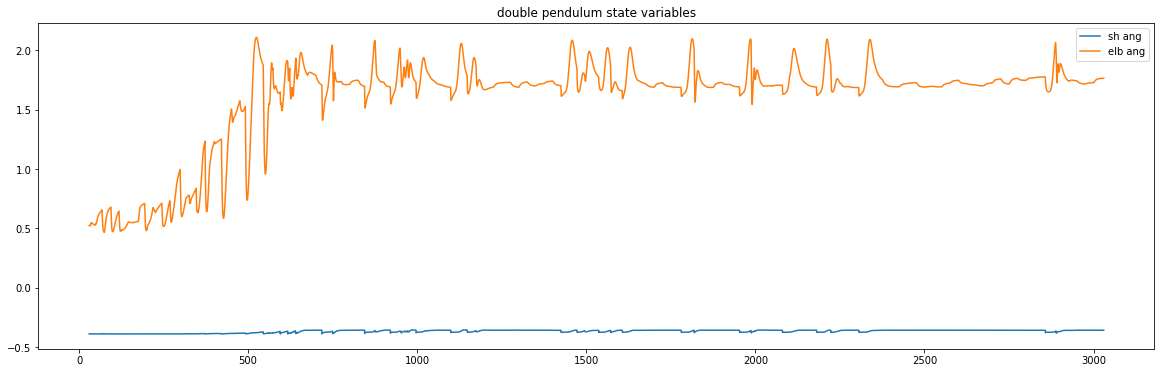

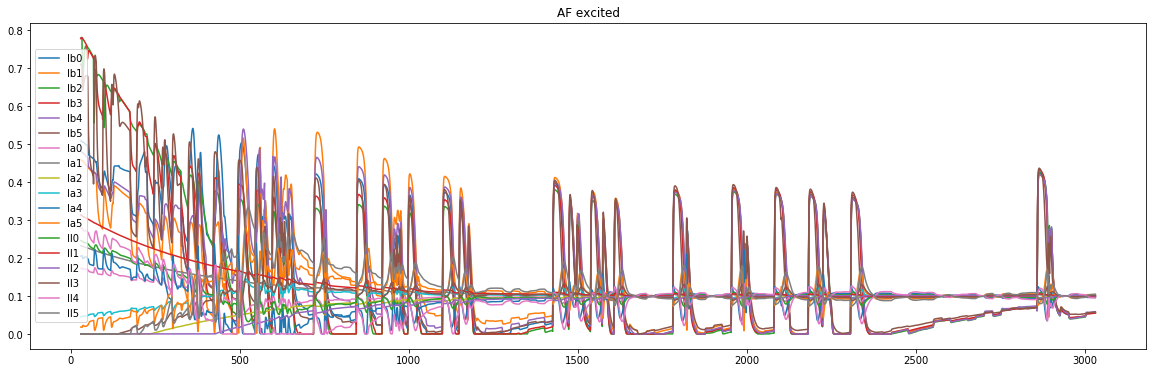

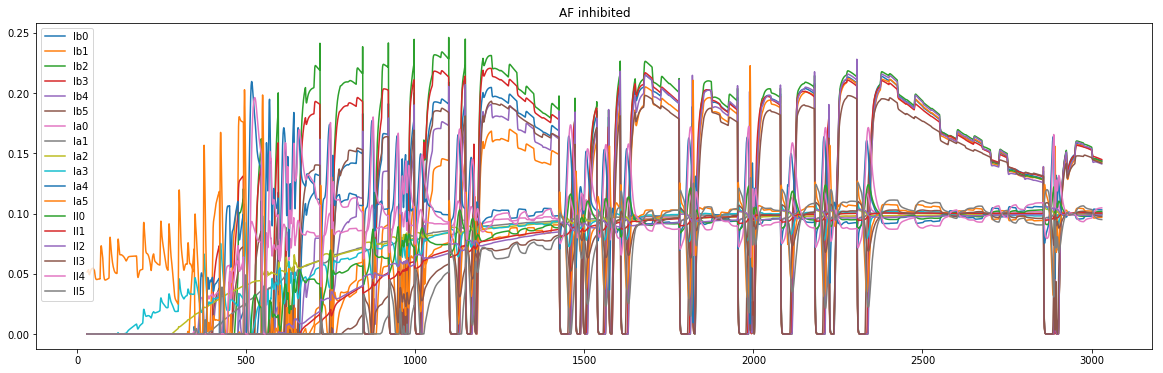

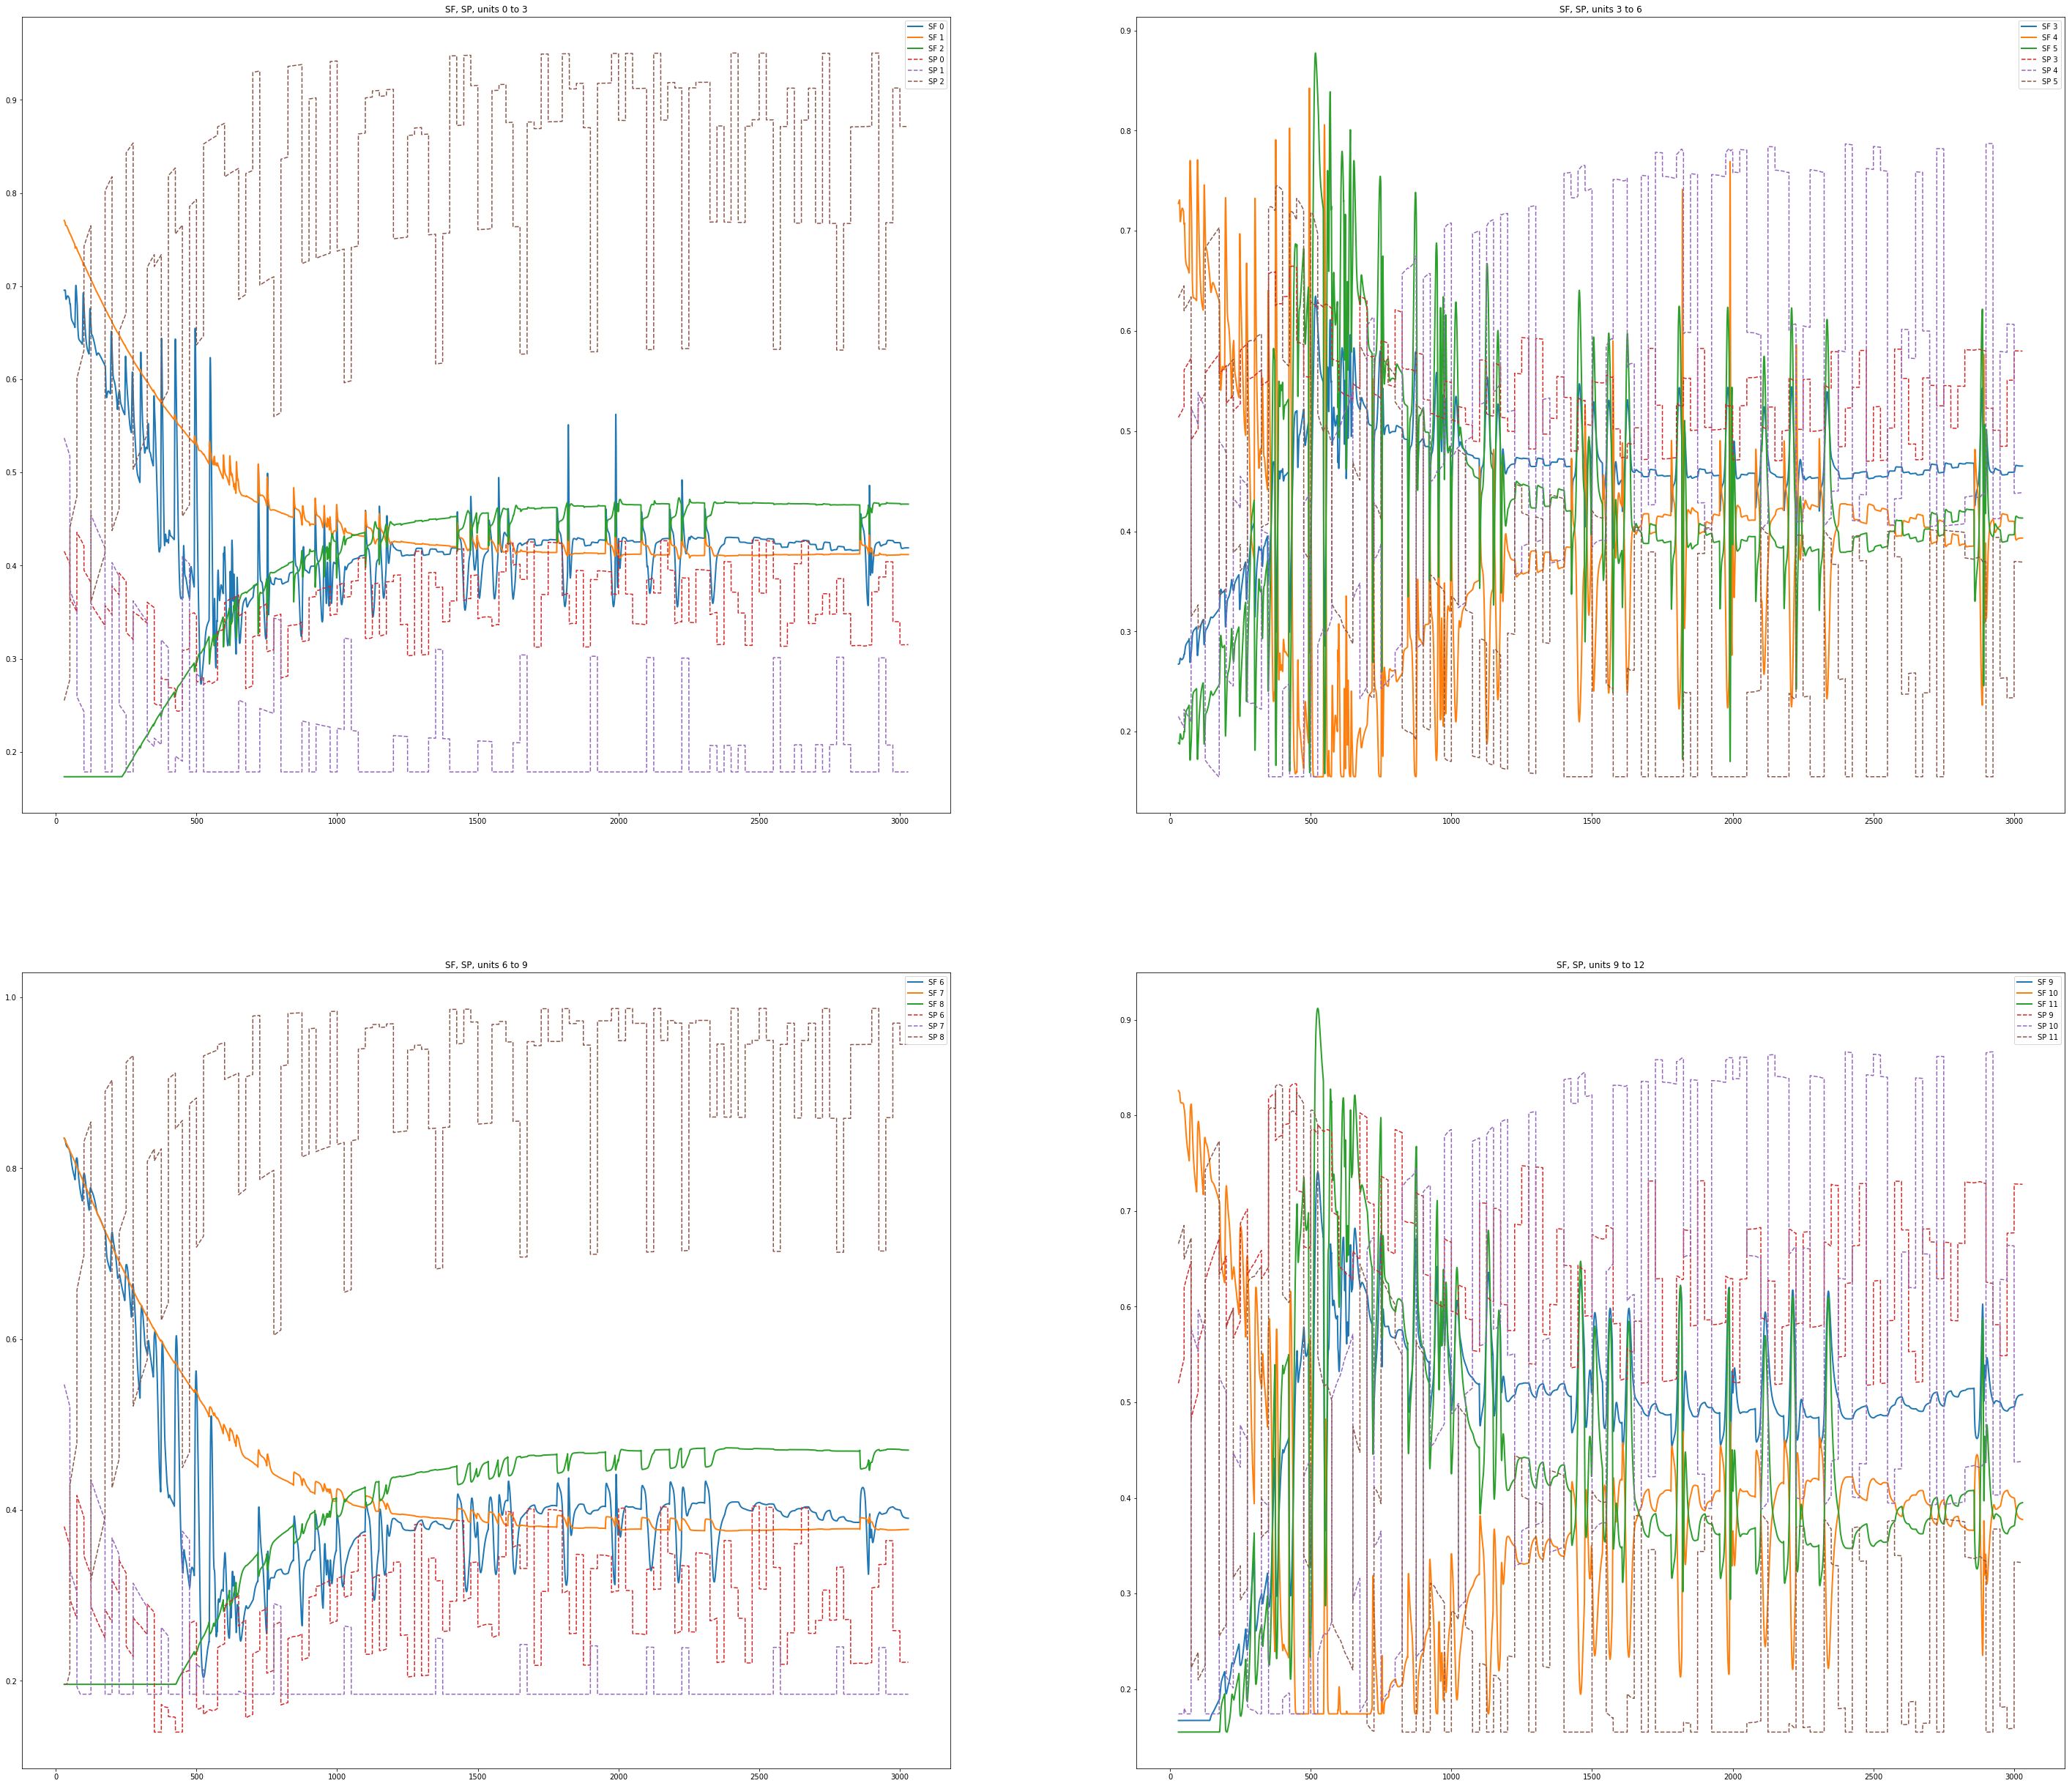

SF = 
[0.41903051 0.41182932 0.46597688 0.46513172 0.39323828 0.41319769
 0.39024845 0.37722329 0.47005863 0.50807008 0.37750643 0.39507102]
SP = 
[0.31513177 0.17845504 0.87137458 0.57984096 0.43858432 0.36919705
 0.22190768 0.18433485 0.9450138  0.72792562 0.4382228  0.33238859]


In [24]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

fs = (50,20)
# SF, SP
SF_fig, axs = plt.subplots(2, 2, figsize=(fs[0], 2.2*fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        base = 3*col + 6*row
        ax.plot(times, SF_data[base:base+3, :].transpose(), linewidth=2)
        ax.plot(times, SP_data[base:base+3, :].transpose(), '--')
        ax.set_title('SF, SP, units %d to %d' % (base, base+3))
        SF_legends = ['SF '+ str(base+i) for i in range(3)]
        SP_legends = ['SP '+ str(base+i) for i in range(3)]
        ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


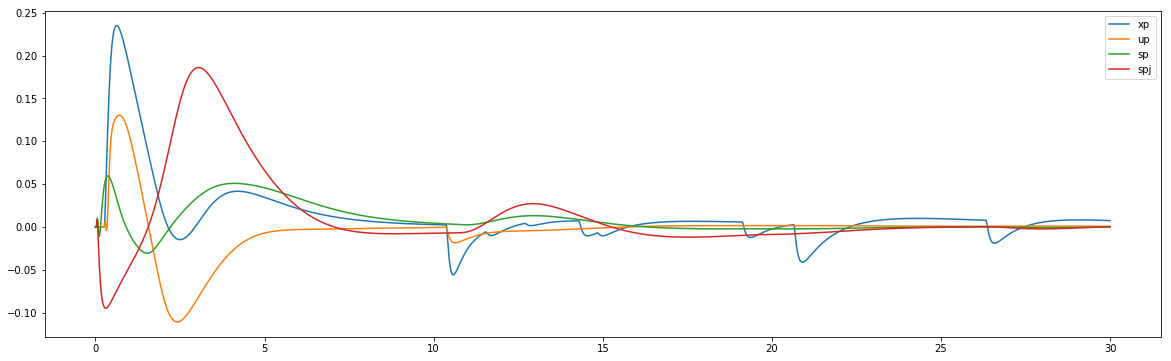

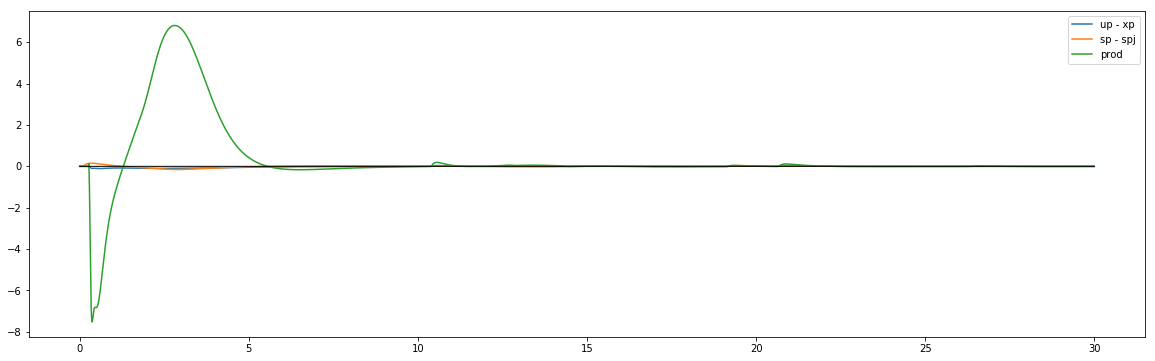

In [11]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

AL_data:
[0.42319246 0.37454903 0.86754414 0.86329845 0.40685259 0.73556834]


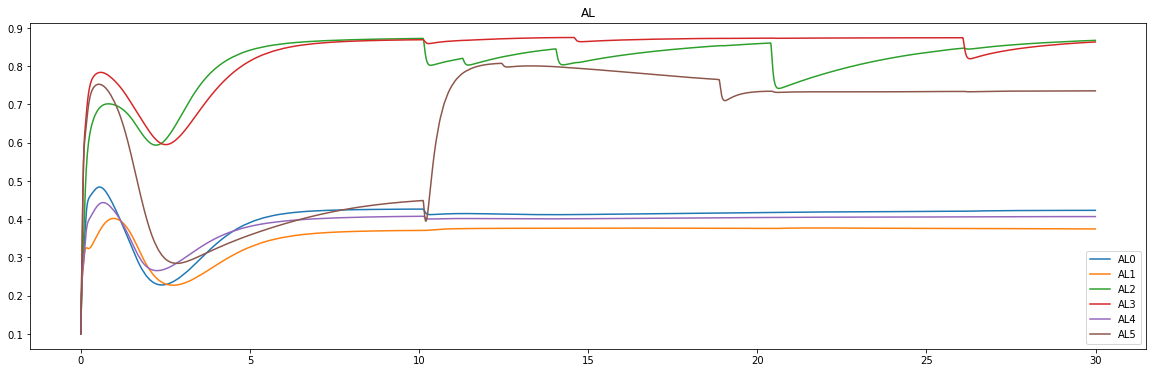

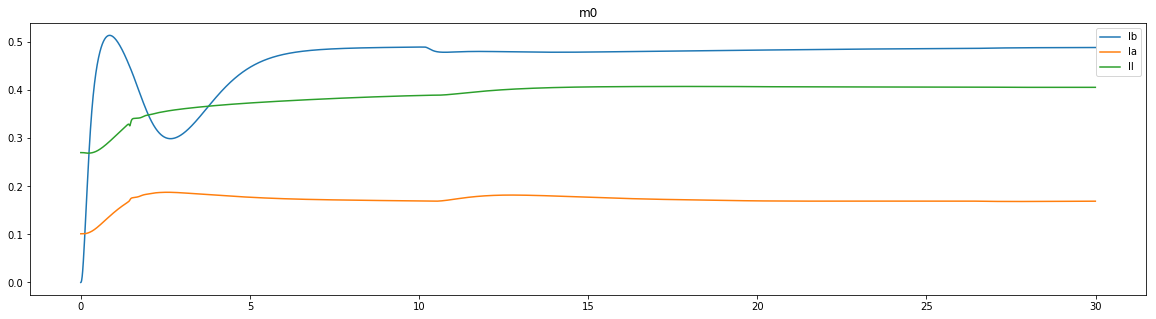

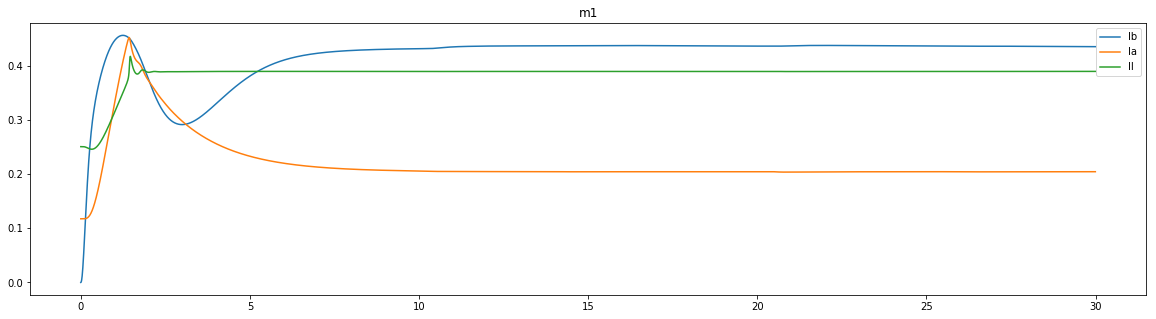

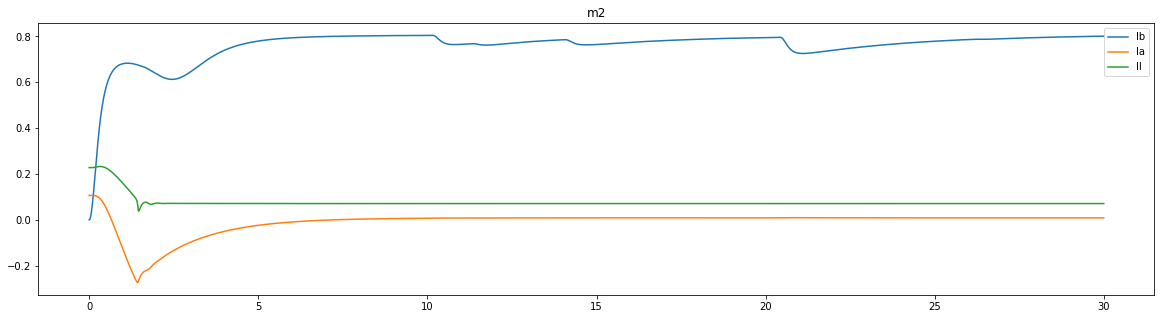

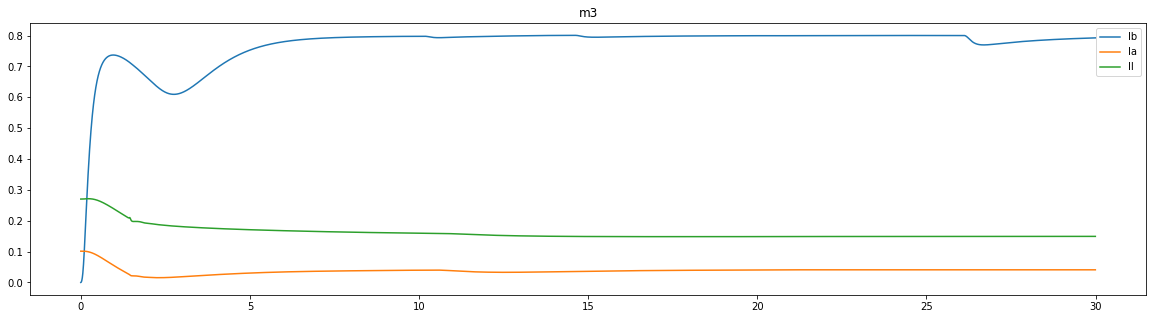

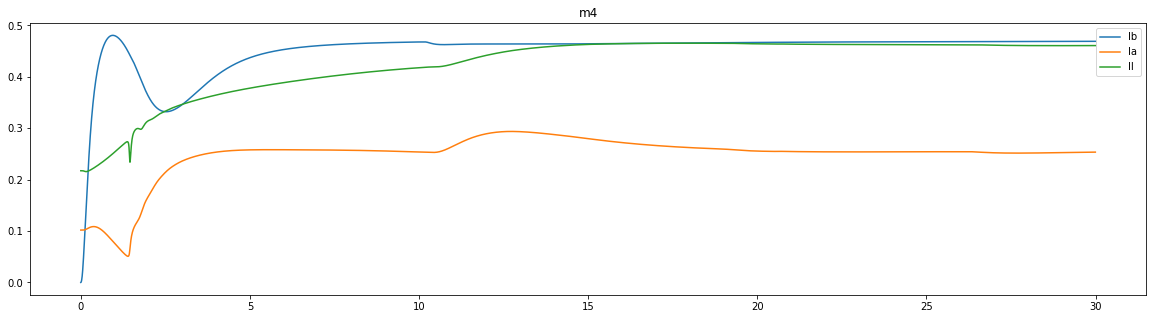

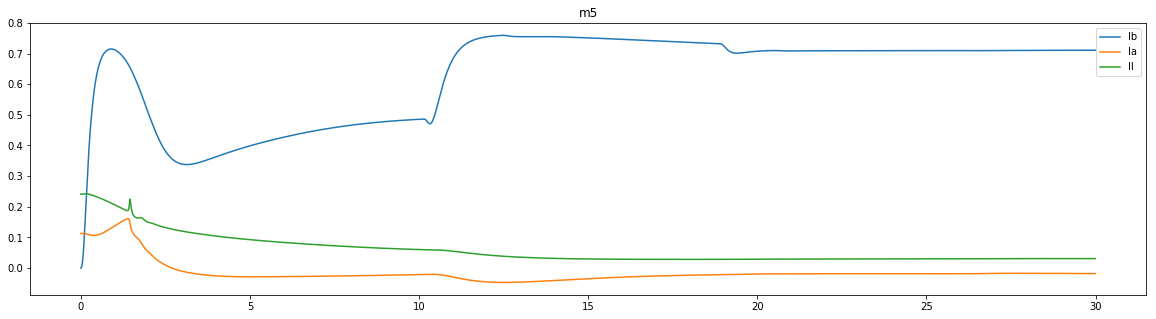

In [12]:
# Alpha units
AL_fig = plt.figure(figsize=fs)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
plt.show()

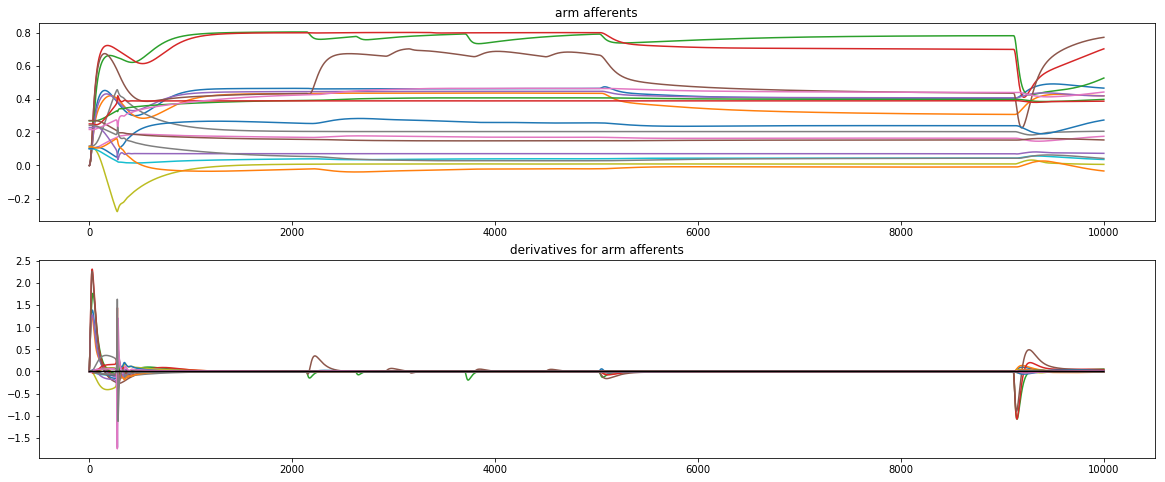

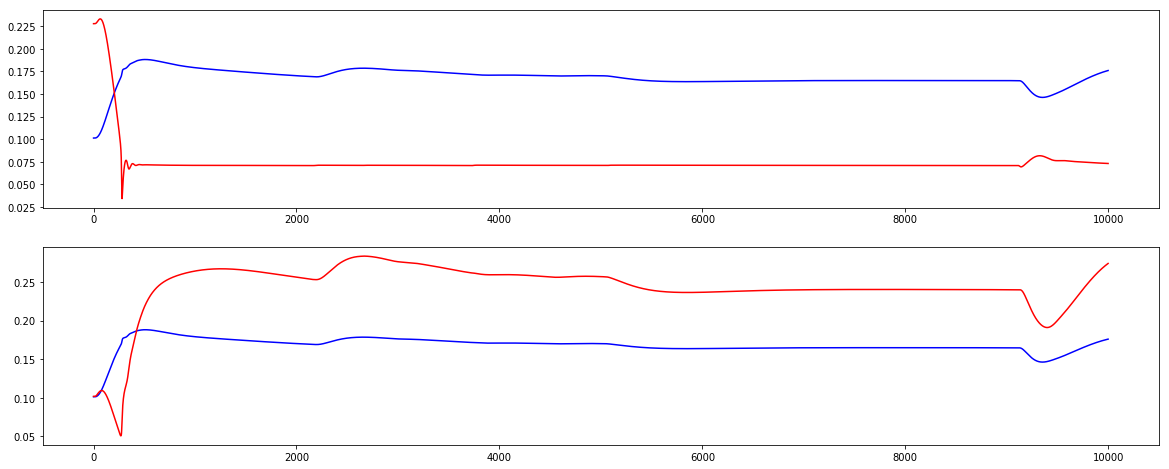

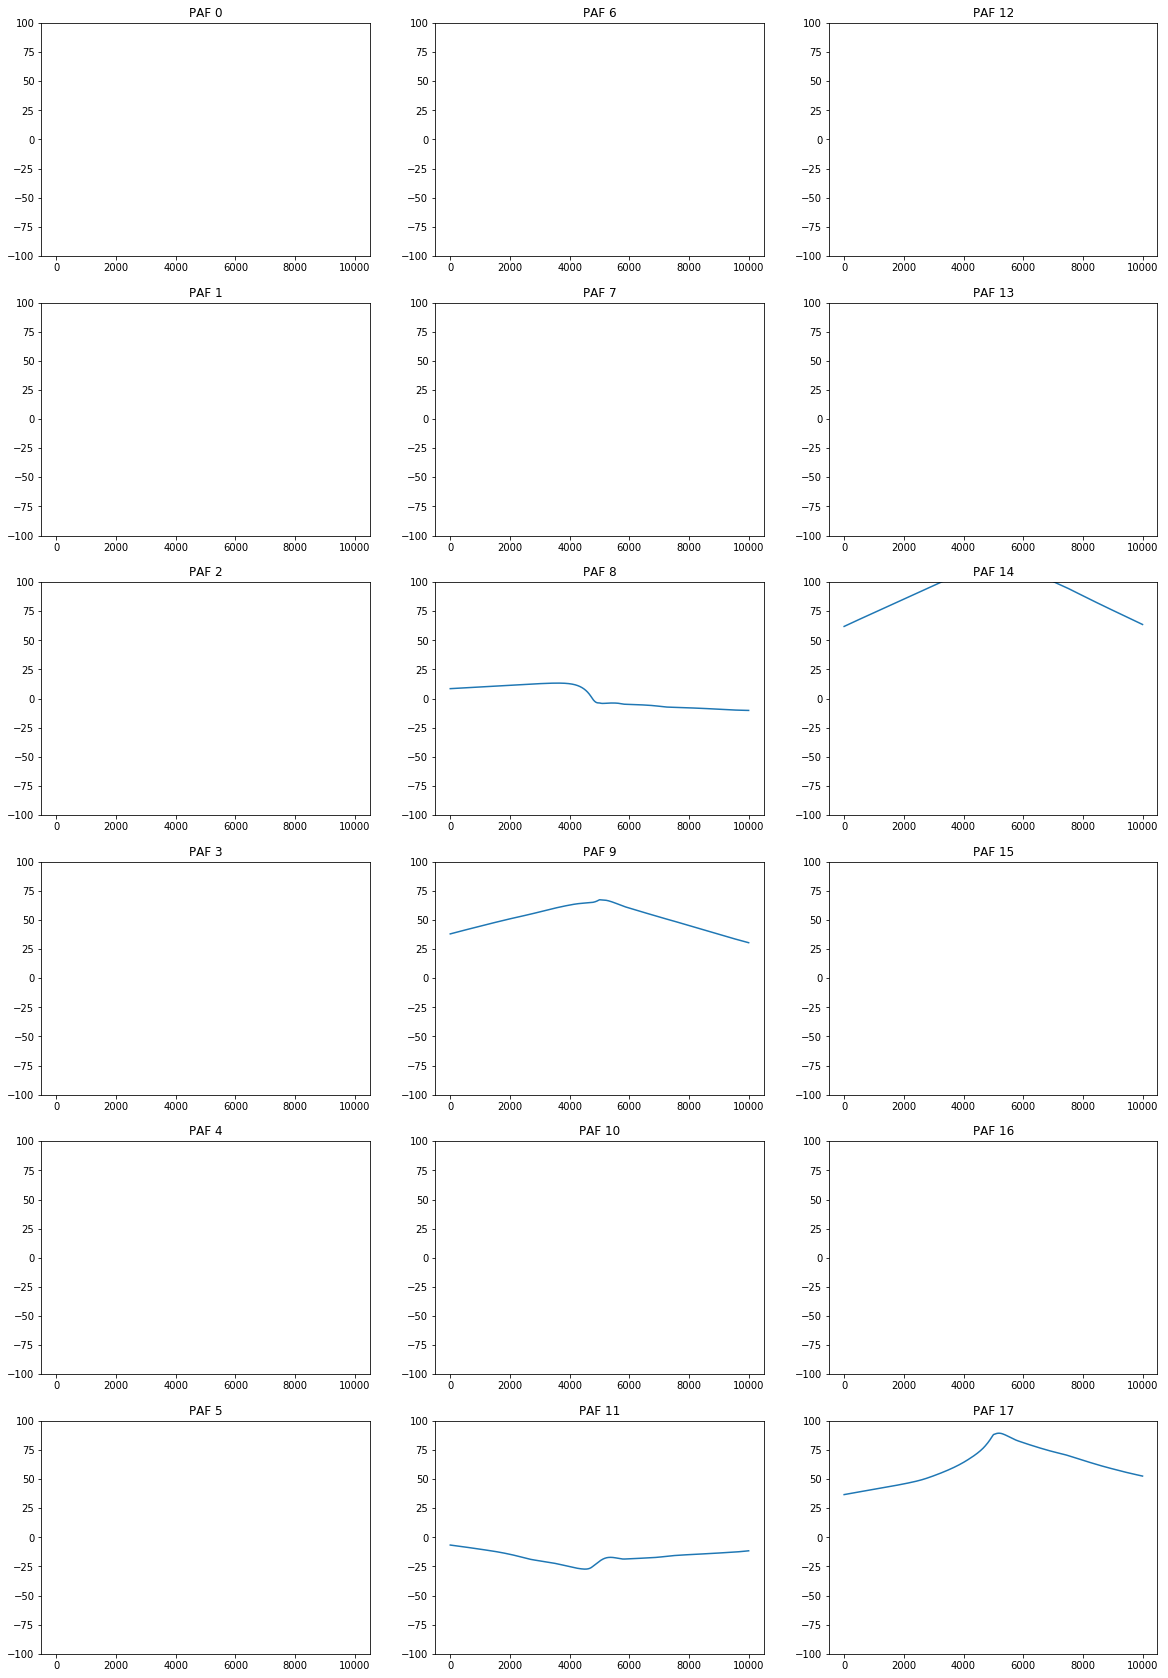

In [16]:
# ANALYSIS OF CORRELATIONS BETWEEN ARM AFFERENTS

# obtaining arm afferents and their derivatives
PAF = arm_activs[:10000, 22:40]
PAF_diff = np.gradient(PAF, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF)
axs[0].set_title('arm afferents')
axs[1].plot(PAF_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(PAF_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF[:,6], 'b', PAF[:,14], 'r')
axs[1].plot(PAF[:,6], 'b', PAF[:,10], 'r')

# plotting the correlation of one signal against all others
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
for col in range(3):
    for row in range(6):
        #corr = np.correlate(PAF_diff[:,6], PAF_diff[:, 6*col+row], mode='same')
        corr = np.correlate(PAF[:,6], PAF[:, 6*col+row], mode='same')
        corr_axs[row,col].plot(corr)
        corr_axs[row,col].set_ylim([-100,100])
        corr_axs[row,col].set_title('PAF ' + str(6*col+row))
plt.show()

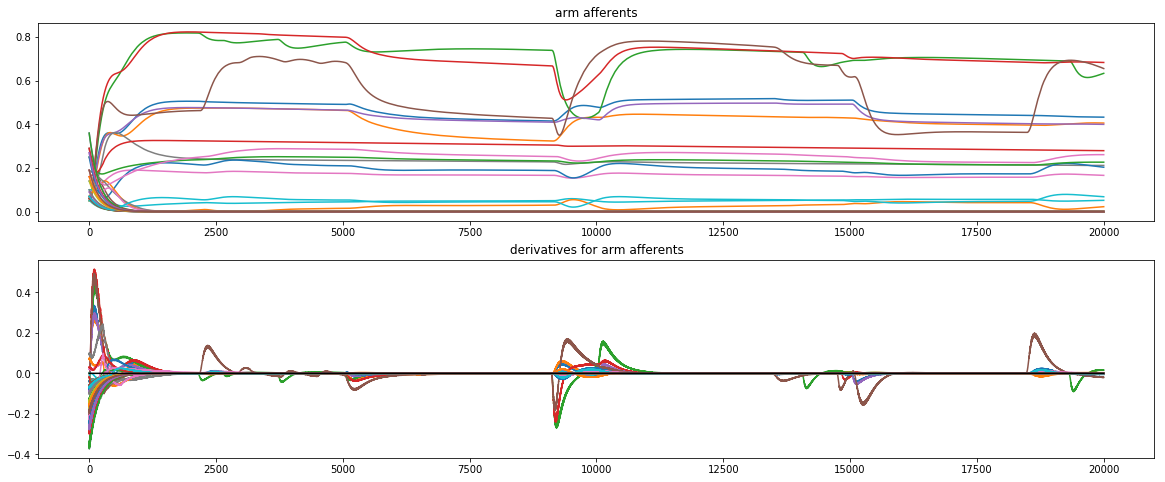

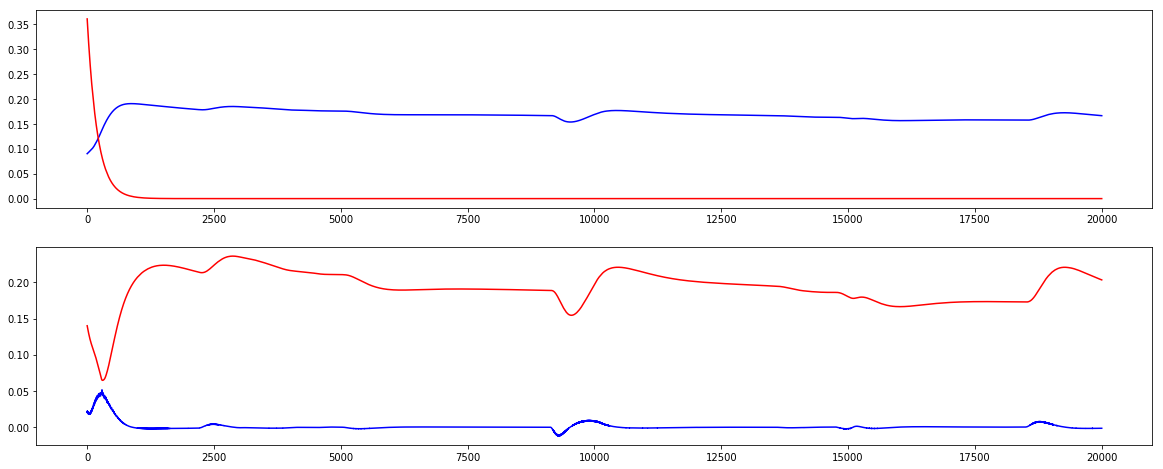

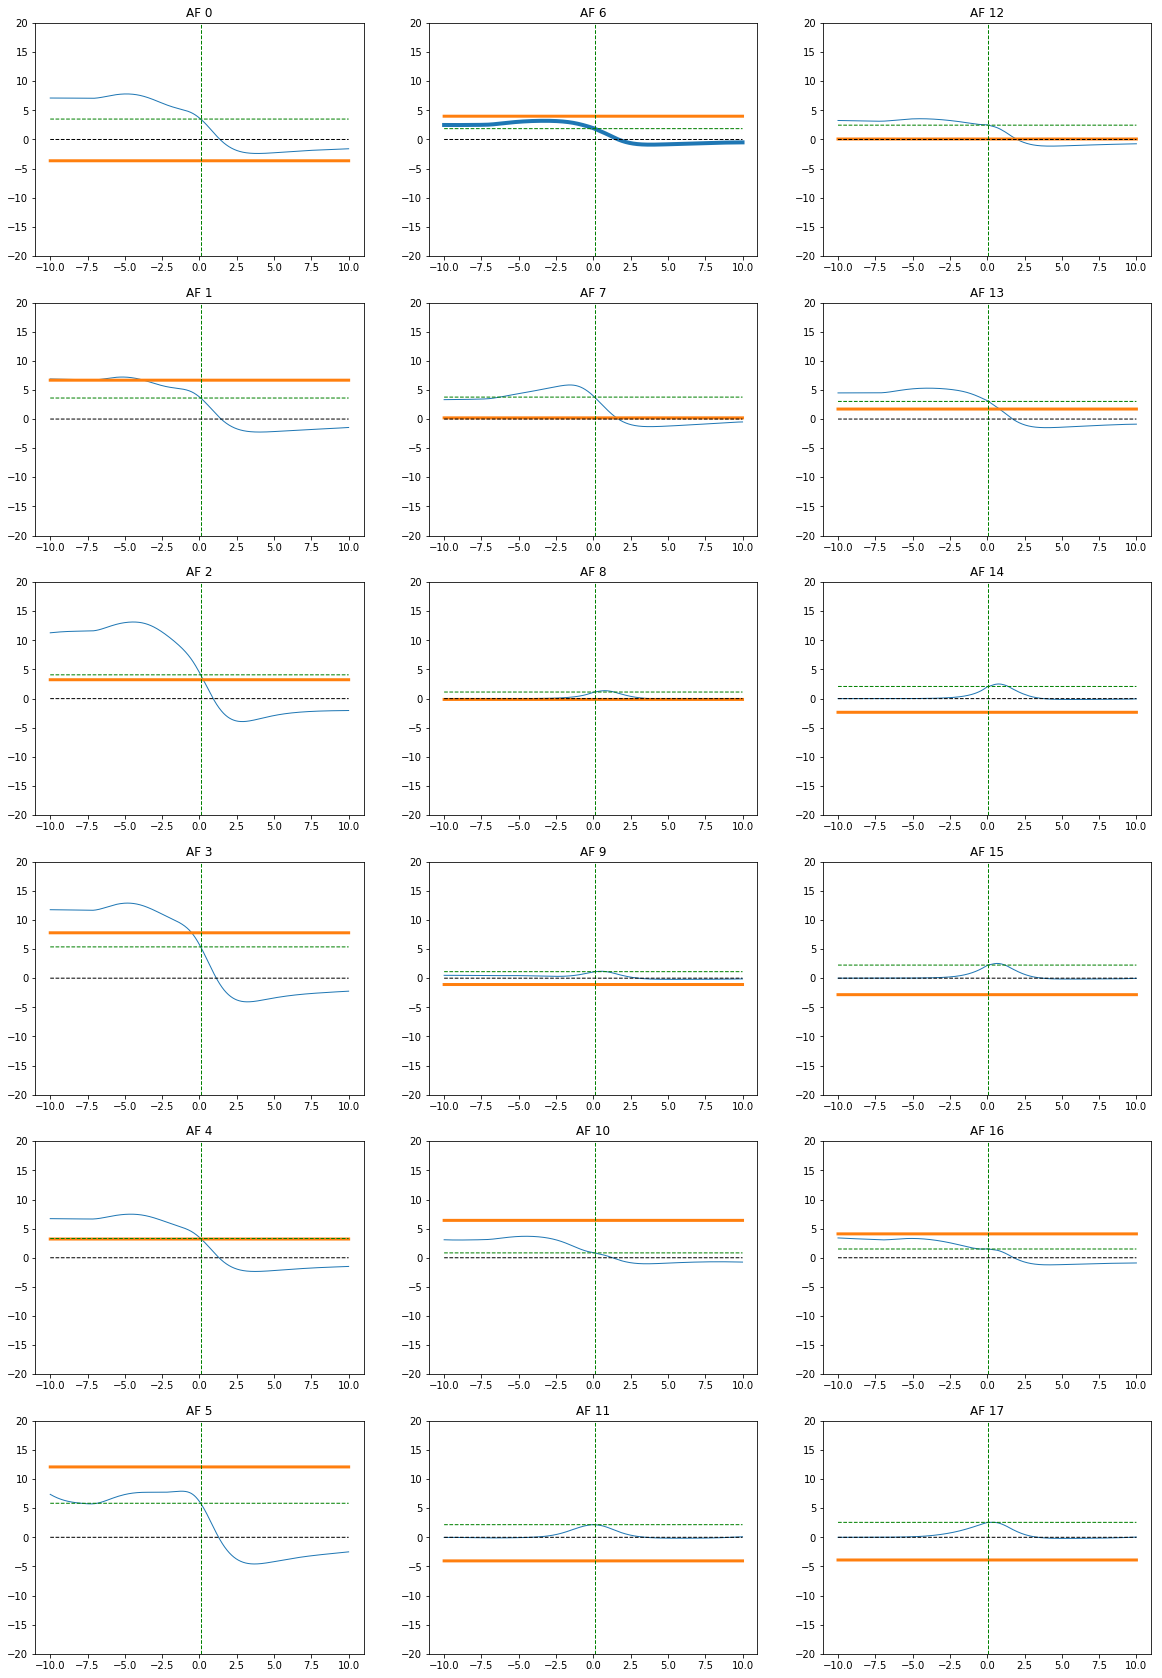

In [17]:
# ANALYSIS OF CORRELATIONS BETWEEN AFFERENT UNITS 
##############################
### NON-NORMALIZED VERSION ###
##############################
# obtaining arm afferents and their derivatives
AFD = data[AF,:20000].transpose()
AFD_diff = np.gradient(AFD, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD)
axs[0].set_title('arm afferents')
axs[1].plot(AFD_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(AFD_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD[:,6], 'b', AFD[:,14], 'r')
axs[1].plot(AFD_diff[:,6], 'b', AFD[:,10], 'r')

# plotting the correlation of one signal against all others
AF__M0_w = [syn.w for syn in net.syns[M[0]] if syn.preID in AF]
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
base_idx = 6 # index for positive Ia afferent for muscle 0
mid = int(round(AFD.shape[0]/2.)) # middle index for the signal (where 0 is)
span = min(2000, mid)   # span to plot for the correlation
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
max_c = 20
min_c = -20
des_val_idx = mid + AF__M_syn['extra_steps']
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD[:,cur_idx], mode='same') # what M0 should be obtaining?
        corr_axs[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs[row,col].set_ylim([min_c,max_c])
        corr_axs[row,col].plot(t, 10.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('AF ' + str(cur_idx))
plt.show()

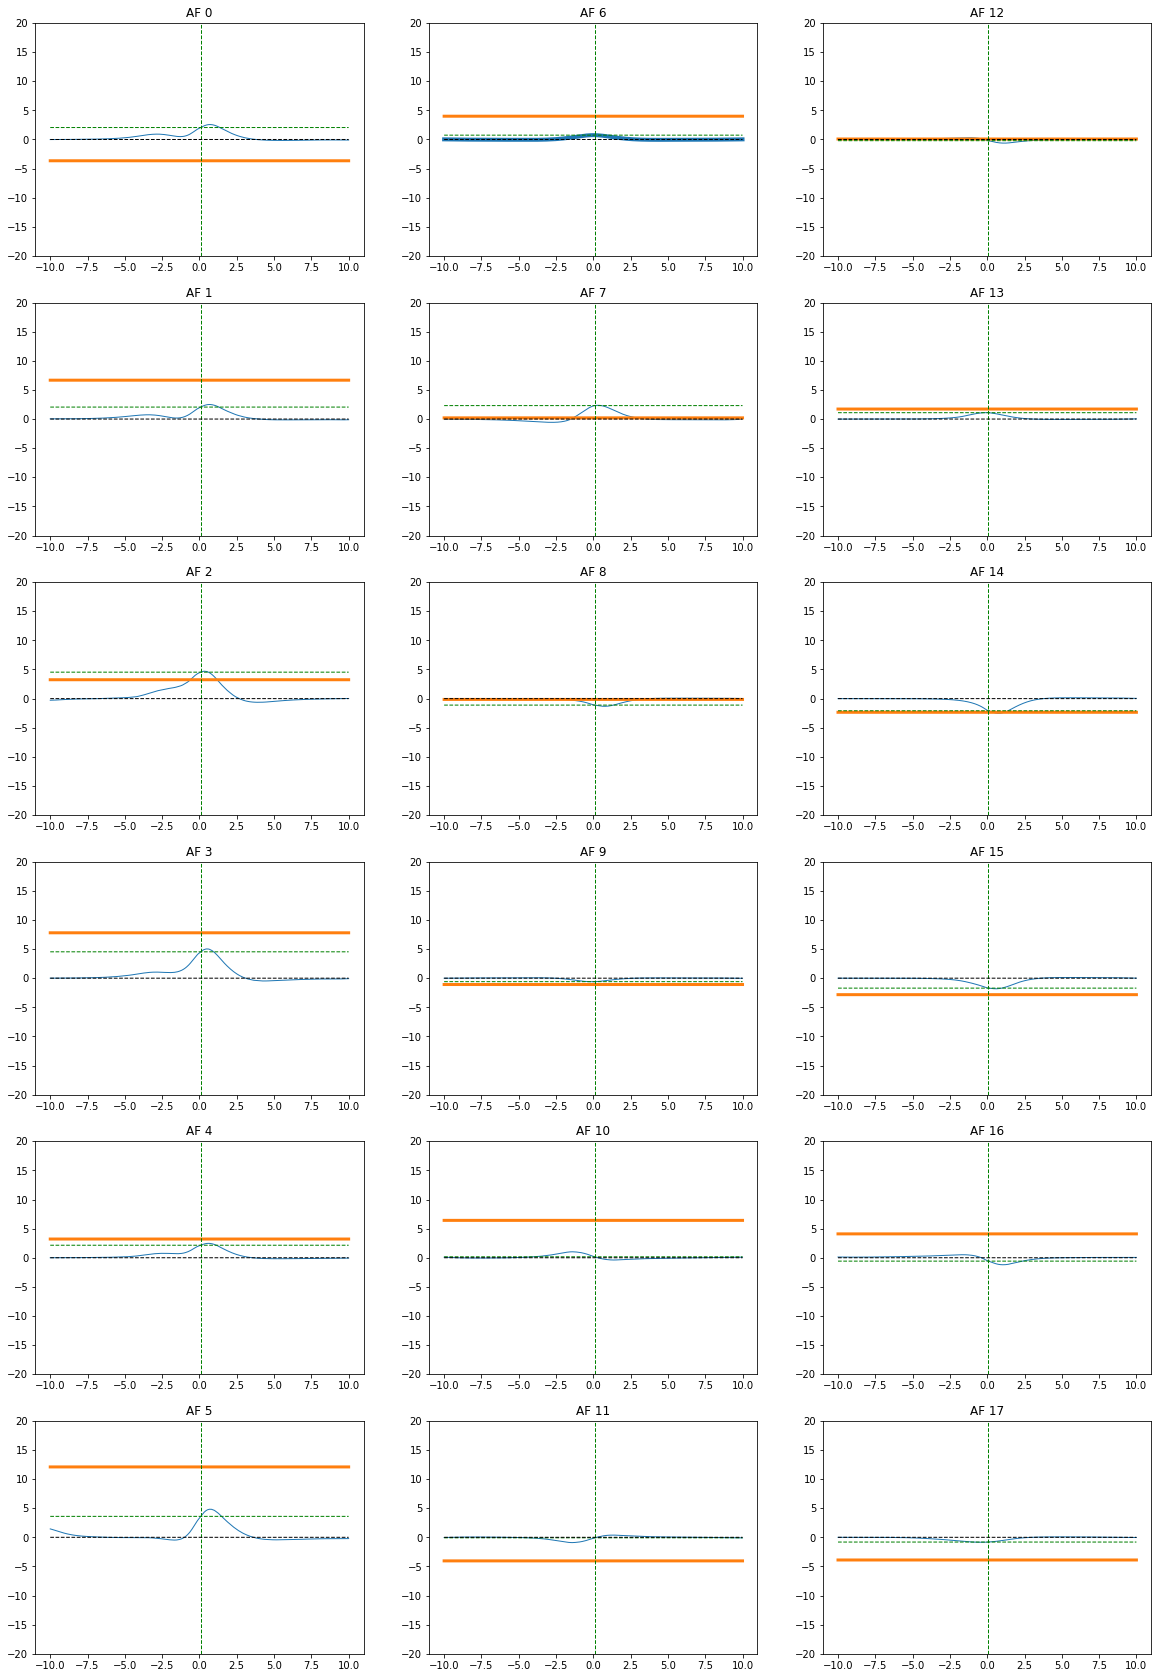

In [18]:
# plotting AF_diff VS AF_diff instead of AF_diff VS AF, to see if 
# the correlations are more informative
corr_fig2, corr_axs2 = plt.subplots(6, 3, figsize=(20,30))
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD_diff[:,cur_idx], mode='same')
        corr_axs2[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs2[row,col].set_ylim([min_c,max_c])
        corr_axs2[row,col].plot(t, 10.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs2[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        corr_axs2[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs2[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs2[row,col].set_title('AF ' + str(cur_idx))
plt.show()

In [14]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


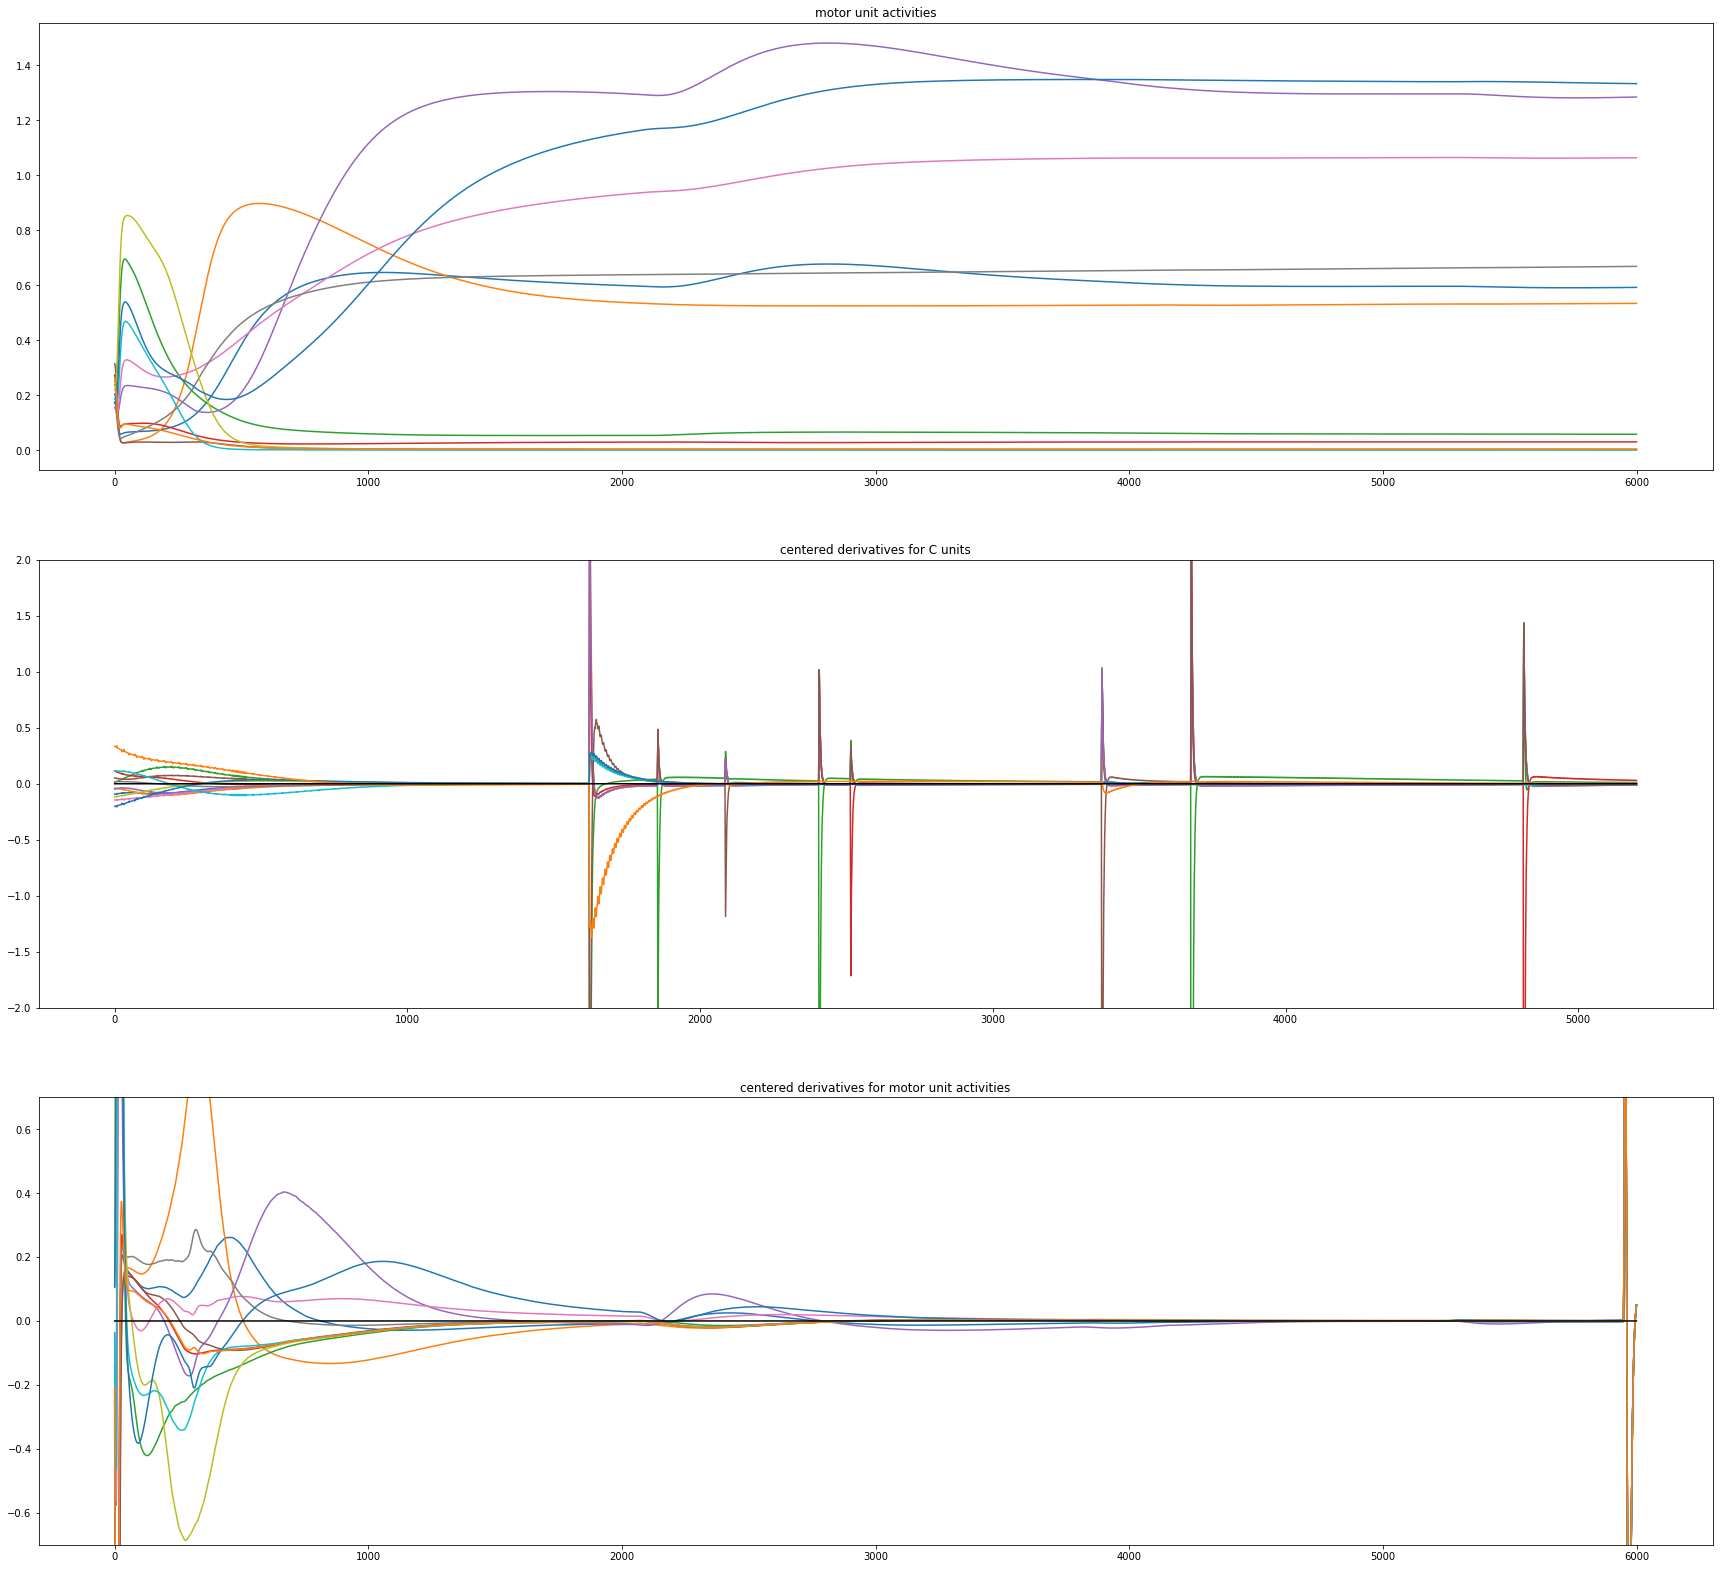

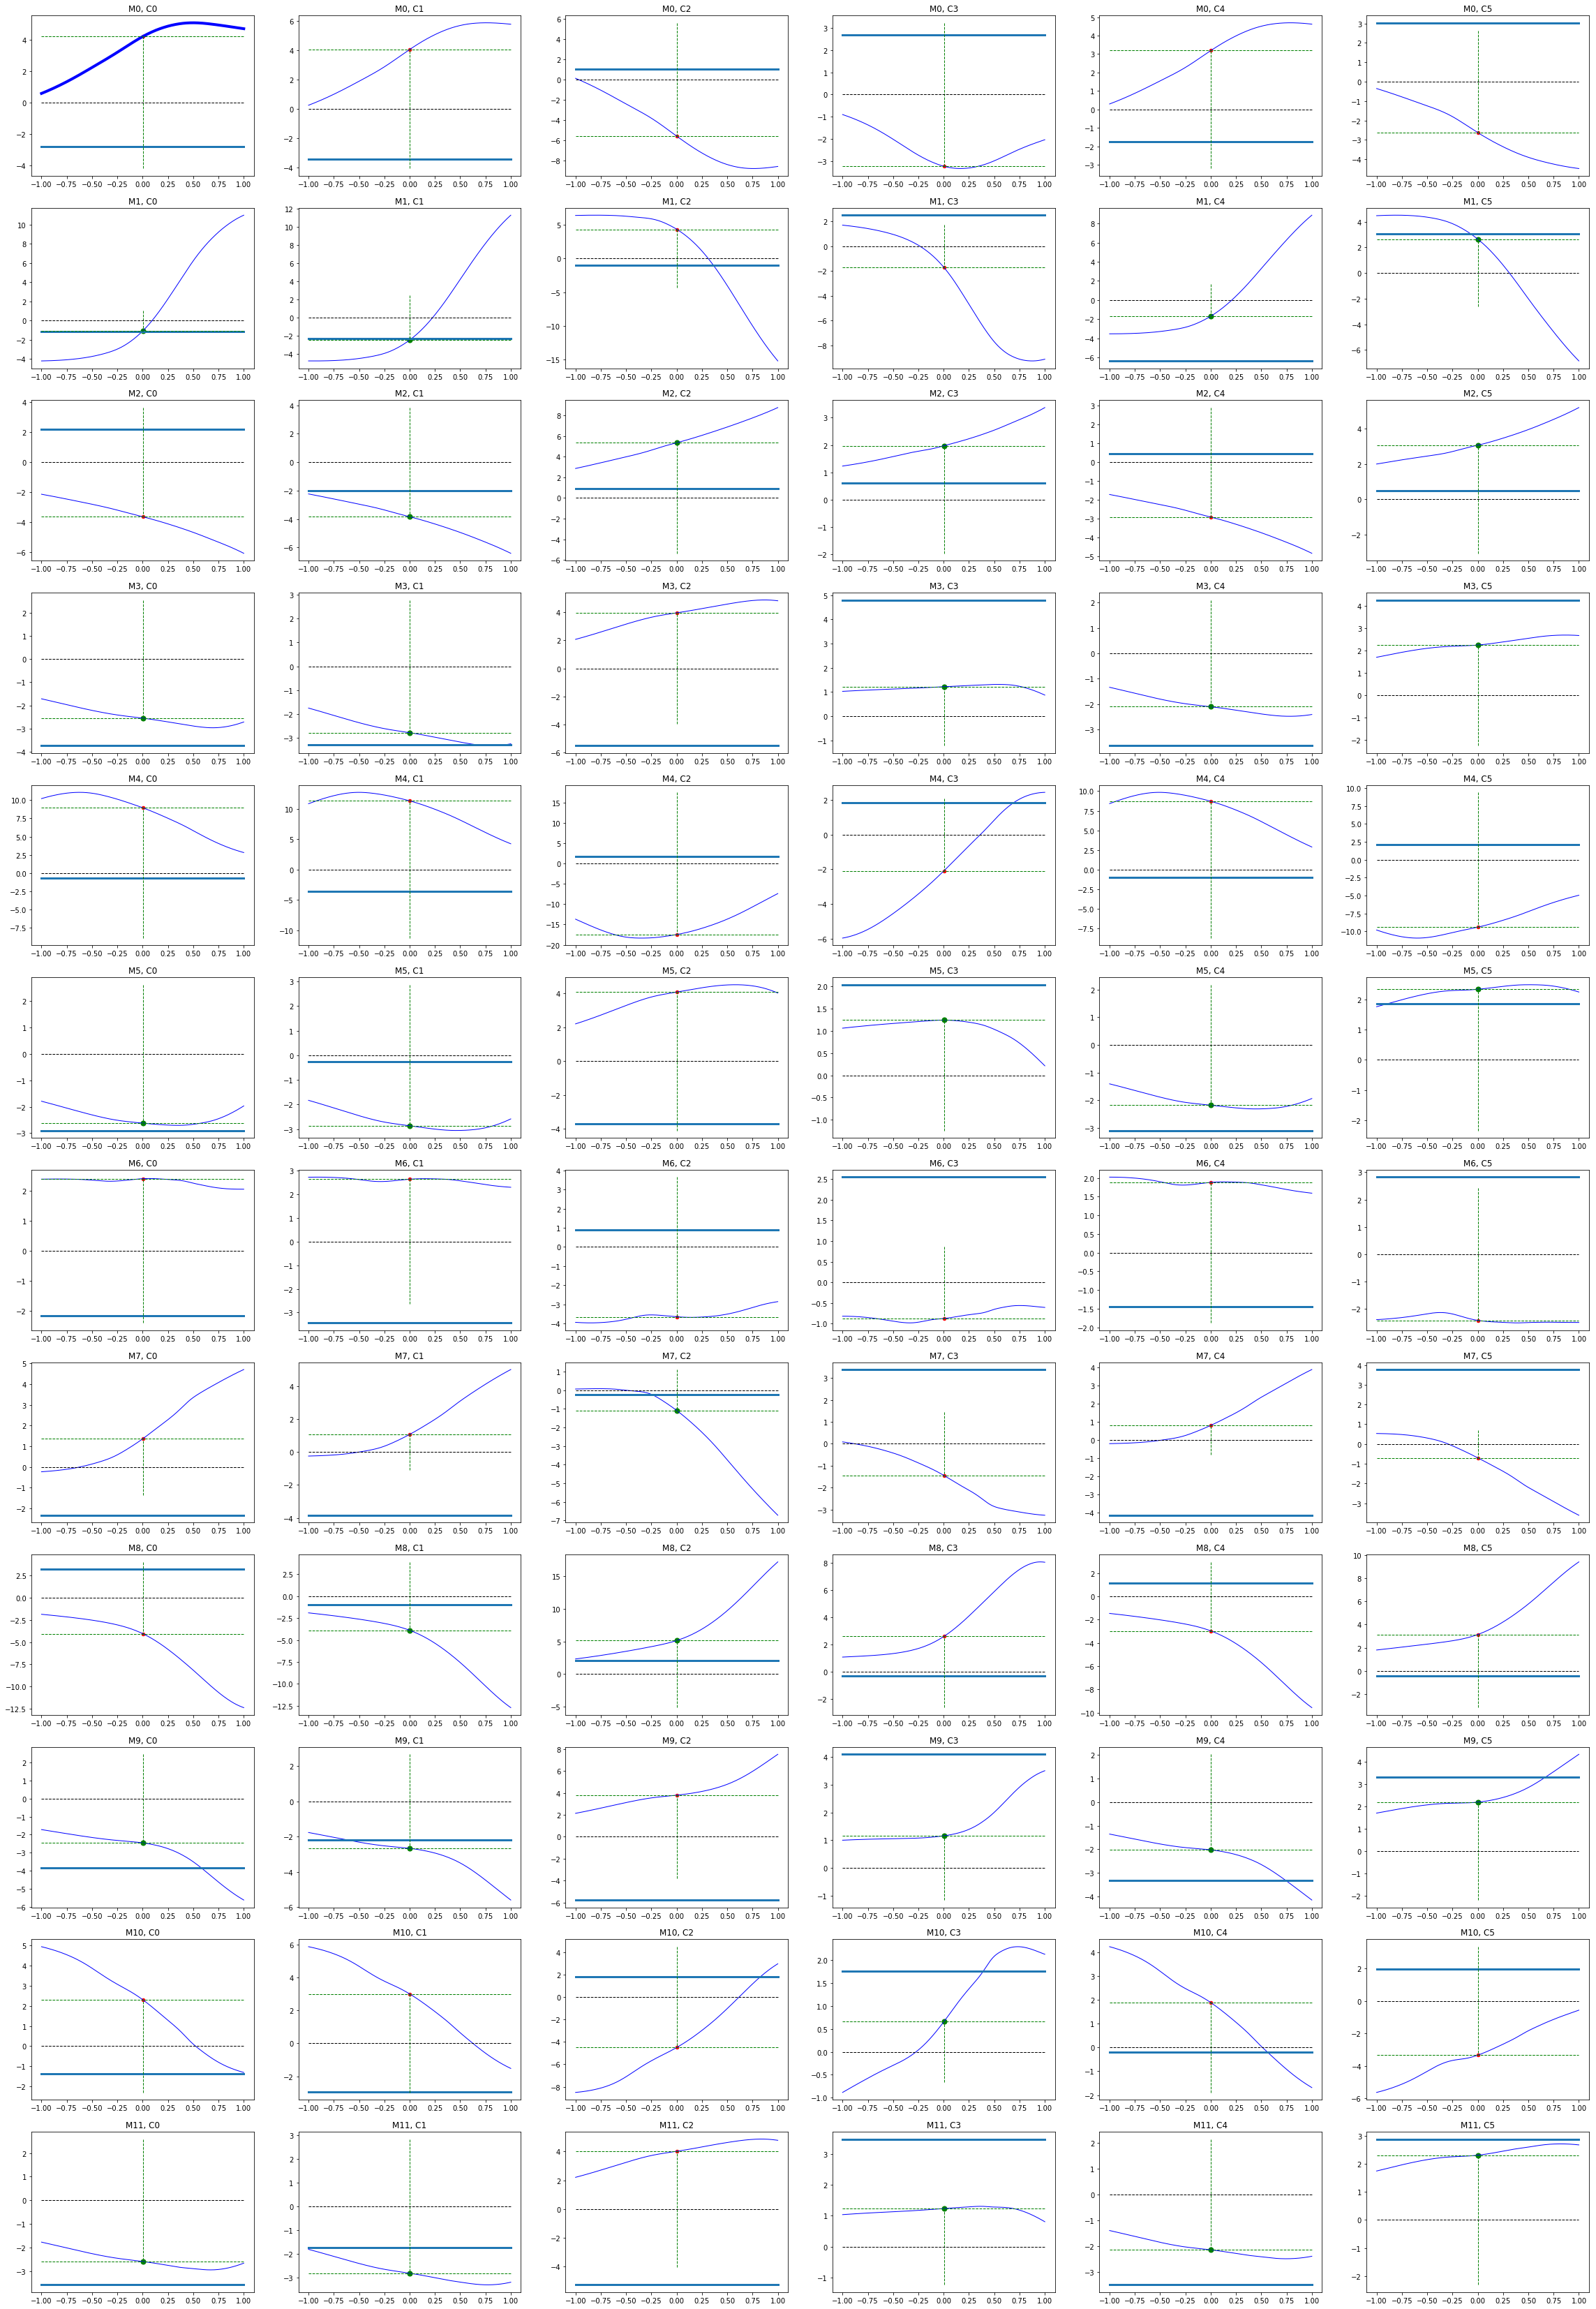

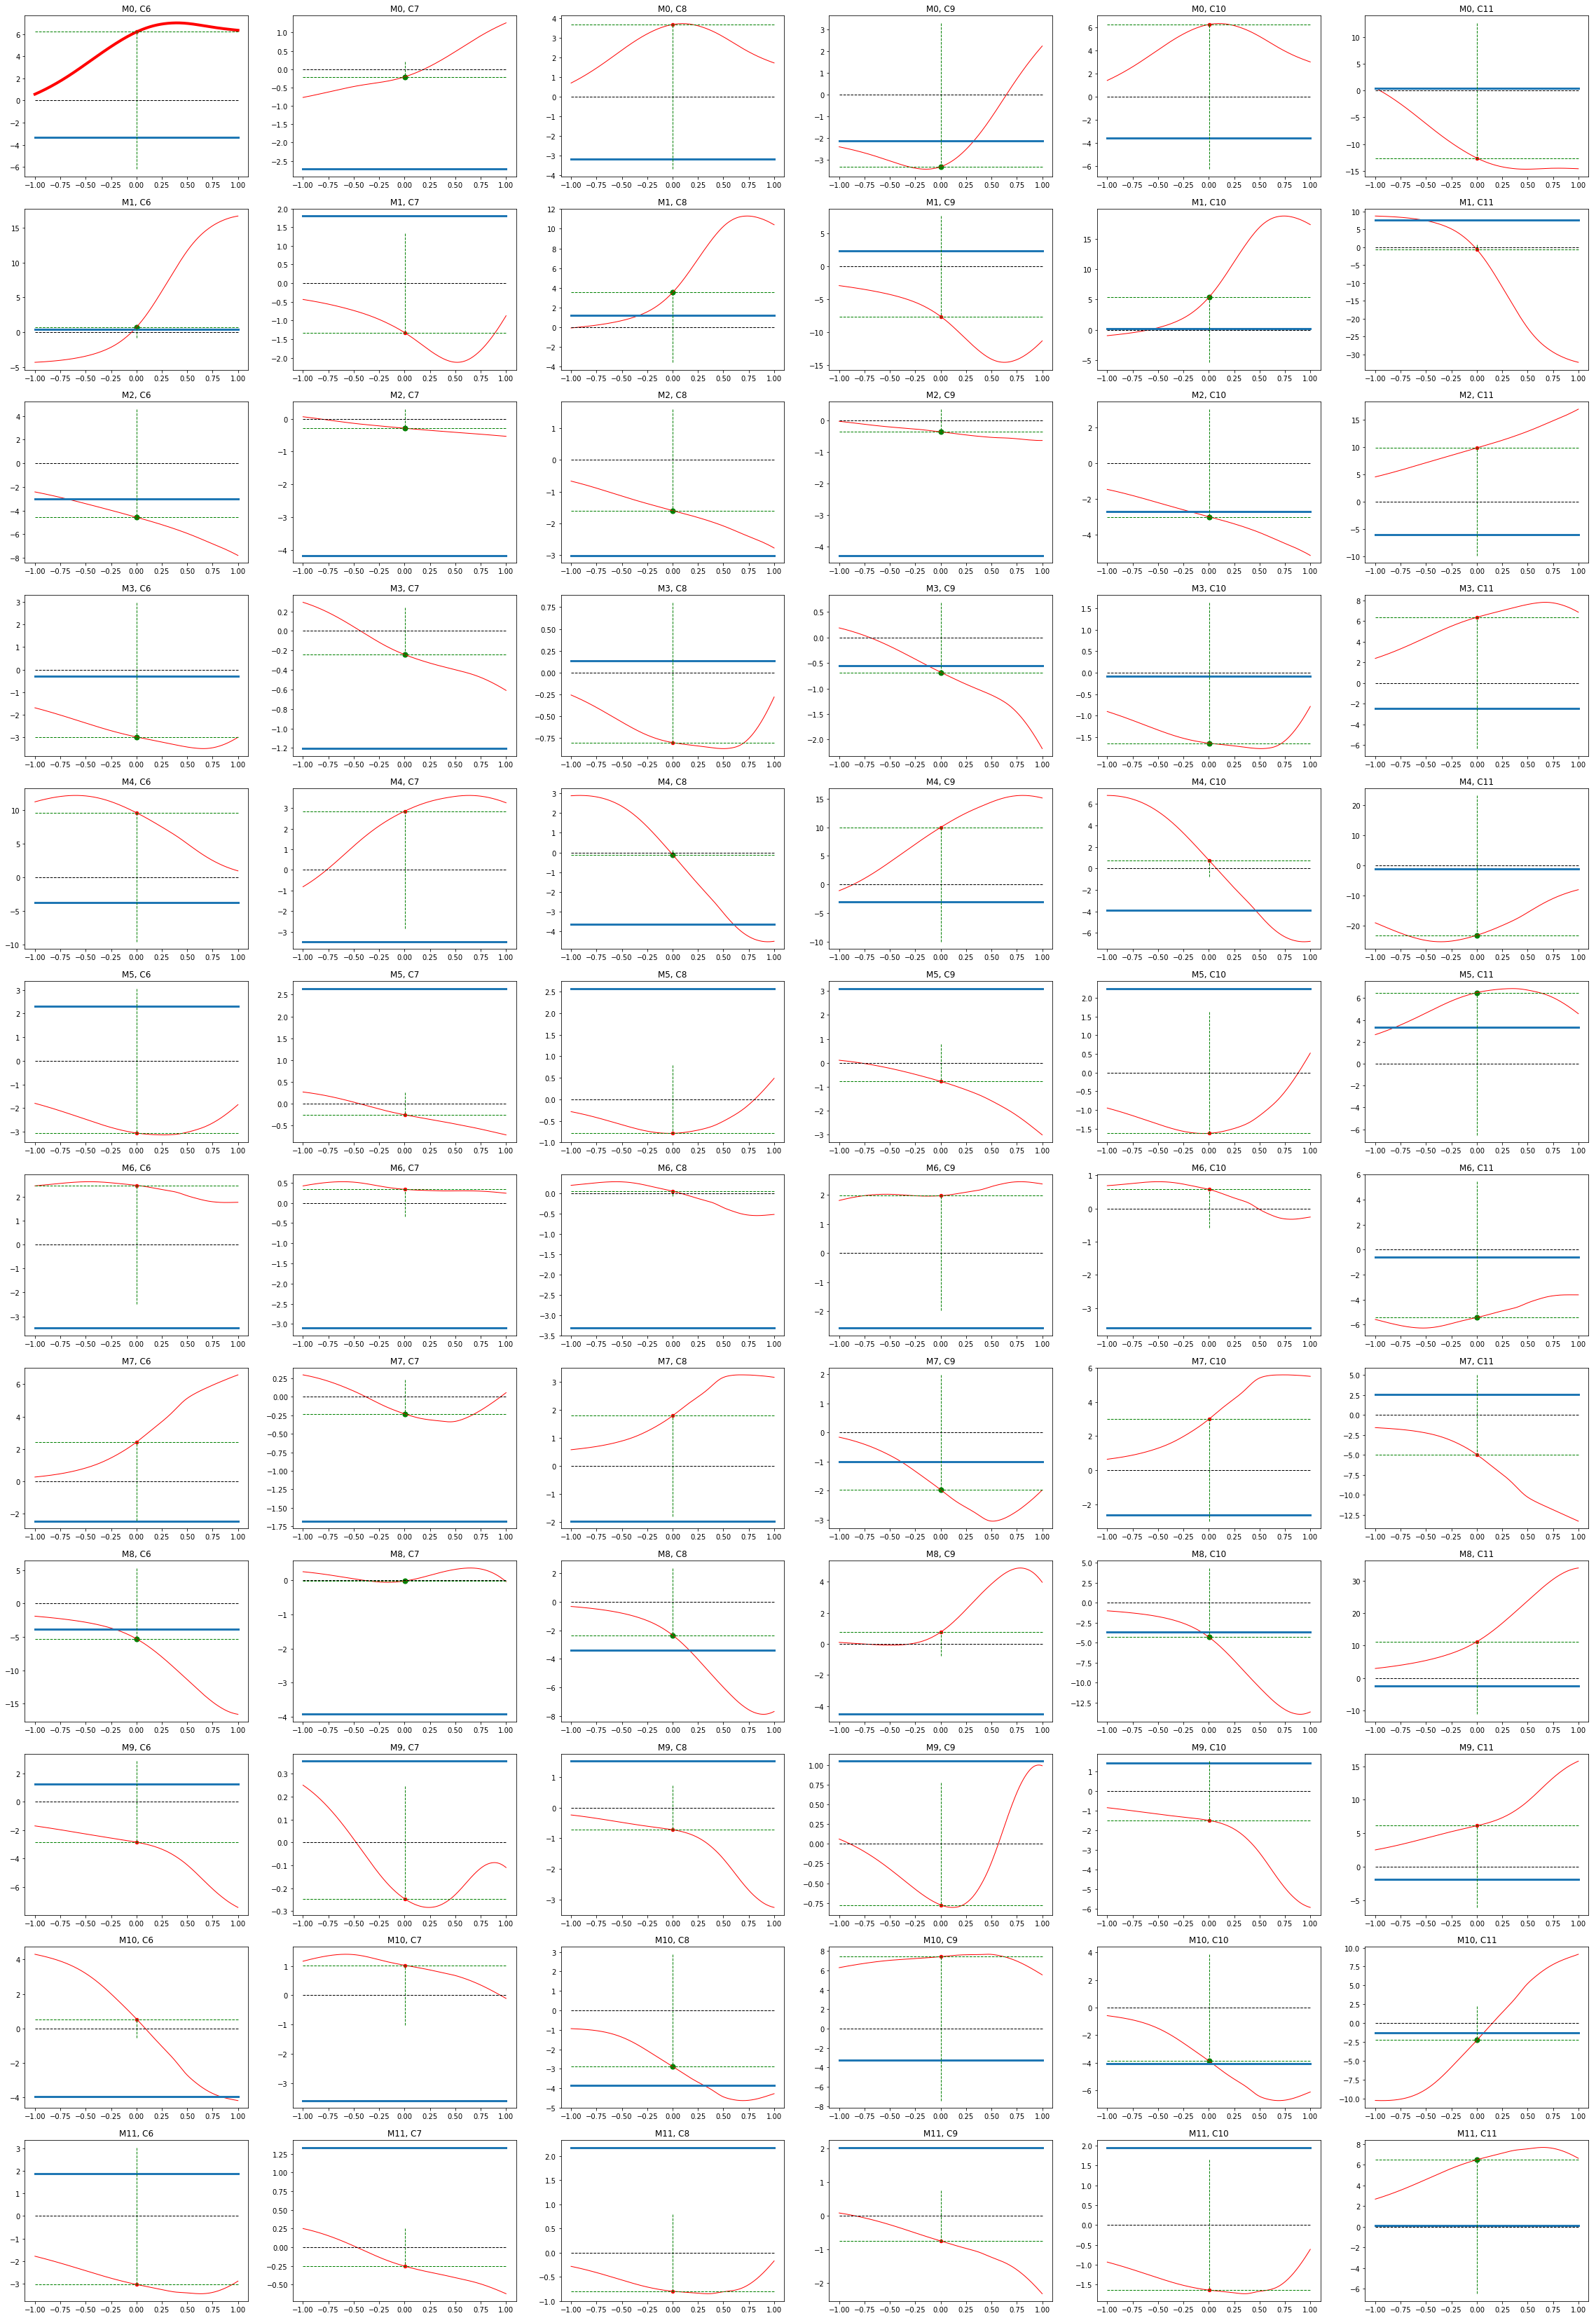

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.]]
[5. 7. 3. 6. 5. 6. 4. 5. 5. 4. 5. 5.]
[2. 7. 9. 9. 2. 6. 1. 3. 6. 5. 4. 6.]
0.4166666666666667
normalized M__CE correlation weight matrix:
[[ 0.32526441, 0.26920524, -0.24923922, -0.52564267, 0.27835891, -0.20844721]
, [-0.08248469, -0.16266051, 0.19086129, -0.28014505, -0.14622812, 0.20744624]
, [-0.28103682, -0.2544628, 0.23774621, 0.3215822, -0.25322028, 0.2422073, ]
, [-0.19675017, -0.18359891, 0.1756753, 0.19890456, -0.18375811, 0.17824091]
, [ 0.69096296, 0.74745022, -0.77484115, -0.34080374, 0.75860781, -0.74365767]
, 

In [18]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS AND C UNITS

# obtaining M,C unit activities and their derivatives
full_size = len(data[M[0]])
M_size = 6000 # number of points we will take from the M data signals
C_span = 2600 # number of points in half of the C data moving window
center_idx = int(round(full_size/2))
MD = data[M, center_idx-int(M_size/2):center_idx+int(M_size/2)].transpose()
#MD = data[M, -M_size:].transpose()
w_l = 31
for idx in range(len(M)): # smoothing MD
    MD[:,idx] = smooth(MD[:,idx], window_len=w_l)[int(np.floor(w_l/2)):-int(np.floor(w_l/2))]
MD_diff = np.gradient(MD, axis=0) / net.min_delay
MD_diff_roll = np.roll(MD_diff, -CE_params['custom_inp_del'], axis=0) # delaying MD_diff
MD_diff_means = np.tile(np.mean(MD_diff_roll, axis=1), (12,1)).transpose()
MD_diff_center = MD_diff - MD_diff_means

CD = data[CE+CI, center_idx-C_span:center_idx+C_span].transpose()
CD_diff = np.gradient(CD, axis=0) / net.min_delay
#CD_diff_means = np.tile(np.mean(CD_diff, axis=1), (12,1)).transpose()
# Currently, for CE units we remove the mean of the other CE units, and for
# CI units we remove the mean of the other CI units, reflecting the
# port scheme in the C__C connectivity
CD_diff_means = np.zeros((2*C_span,12))
for idx in range(6):
    CD_diff_means[:, idx] = np.mean(np.delete(CD_diff[:,0:6], np.s_[idx], axis=1), axis=1)
for idx in range(6,12):
    CD_diff_means[:, idx] = np.mean(np.delete(CD_diff[:,6:12], np.s_[idx-6], axis=1), axis=1)
CD_diff_center = CD_diff - CD_diff_means

fig, axs = plt.subplots(3, 1, figsize=(30, 28))
axs[0].plot(MD)
axs[0].set_title('motor unit activities')
axs[1].plot(CD_diff_center)
axs[1].set_title('centered derivatives for C units')
axs[1].plot(np.zeros(CD_diff_center.shape[0]), 'k')
axs[1].set_ylim([-2., 2.])
axs[2].plot(MD_diff_center)
axs[2].set_title('centered derivatives for motor unit activities')
axs[2].plot(np.zeros(MD_diff_center.shape[0]), 'k')
axs[2].set_ylim([-.7, .7])

# plotting the correlation of one signal against all others
M__CE_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CE]
corr_figE, corr_axsE = plt.subplots(12, 6, figsize=(40,60))

M__CI_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CI]
corr_figI, corr_axsI = plt.subplots(12, 6, figsize=(40,60))

base_idx = 0 # index for positive Ia afferent for muscle 0
mid = int(round((M_size - 2*C_span)/2)) # index of the middle 0 shift value
plt_span = min(200, mid)   # span to plot for the correlation
t = np.linspace(-plt_span*net.min_delay, plt_span*net.min_delay, 2*plt_span)
eqs = np.zeros((12,12)) # matrix indicating whether weight and correlation have same sign
corr_w = np.zeros((12,12)) # what the weight should be, according to the correlation
des_val_idx = mid #+ CE_params['custom_inp_del']

for col in range(12):  # ranges through C units
    if col < 6:
        axes = corr_axsE
        weights = M__CE_w
        color='b'
    else:
        axes = corr_axsI
        weights = M__CI_w
        color='r'
    mcol = col%6
    for row in range(12):  # ranges through units
        cur_idx = 12*mcol+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(CD_diff_center[:,col], -MD_diff_center[:,row], mode='valid')
        axes[row,mcol].plot(t, corr[mid-plt_span:mid+plt_span], linewidth=lw, color=color)
        corr_w[row,col] = corr[des_val_idx]
        axes[row,mcol].plot(t, 5.*weights[mcol][row]*np.ones(len(t)), linewidth=3)
        axes[row,mcol].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)] #+ CE_params['custom_inp_del']]
        axes[row,mcol].plot([x, x], [-corr_w[row,col], corr_w[row,col]], 'g--', linewidth=1)
        axes[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        axes[row,mcol].set_title('M' + str(row) + ', C' + str(col))
        # Finding if weights are following the correlations
        scat_s = 20
        scat_c = 'r'
        if np.sign(weights[mcol][row]) == np.sign(corr[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 50
            scat_c = 'g'
        axes[row,mcol].scatter([x], [corr[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(eqs.shape[0]*eqs.shape[1]))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
import re
print('normalized M__CE correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,:6]))))
print('normalized M__CI correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,6:]))))

In [28]:
# Doing a nice print of the AF__M weights in order to initialize them
AF__M_w = np.zeros((len(M), len(AF)))
for idx, mid in enumerate(M):
    AF__M_w[idx, :] = np.array([syn.w for syn in net.syns[mid] if syn.preID in AF])
      
import re

stryn = re.sub('\[,', '[', re.sub('\ +', ', ', str(AF__M_w)))
for c,s in enumerate(re.split(', ', stryn)):
    print(s, end=',')
    if (c+1)%36 == 0: print('\n')


[[-3.05803830e-01,-9.34330320e-02,-1.21172303e-01,2.45893899e-01
,-4.20333566e-01,1.57326764e-01,3.03208393e-01,9.83833568e-01
,-4.21342534e-01,-2.08482912e-01,1.60660359e-01,1.47322119e-04
,3.12100299e-01,6.14540800e-01,-1.92725404e-01,-1.96793297e-01
,2.82486901e-01,-2.33714894e-01,1.26554795e-01,1.15429798e-01
,9.42604627e-02,-1.20367303e-01,3.30791862e-01,-8.66222557e-02
,-2.53382806e-01,-4.18711972e-01,9.94299631e-01,2.49171082e-01
,-6.57588866e-02,1.11397235e-01,-1.96039638e-01,-1.88407634e-01
,6.10874112e-01,2.81384053e-01,-2.48823516e-01,2.53738655e-01]
,

[-1.03792929e-01,7.54643579e-02,3.21217158e-01,2.66999620e-01
,-8.12210671e-02,-1.76877866e-02,1.76909228e-01,1.34269792e+00
,-5.26406481e-01,-1.08602212e-01,-4.02409375e-01,3.48077619e-01
,2.42549196e-01,5.75686044e-01,-1.55594976e-01,-1.46494637e-01
,1.82491878e-01,-1.22135696e-01,4.01234467e-02,-5.01843130e-02
,-1.64429238e-01,-7.55795069e-02,3.87443394e-02,1.55505738e-01
,-1.38303245e-01,-4.91240277e-01,1.32214595e+00,1.4

In [13]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (1) --> M, w=-0.221546, port=0, plant_out=None
1) AF (2) --> M, w=0.589651, port=0, plant_out=None
2) AF (3) --> M, w=0.067021, port=0, plant_out=None
3) AF (4) --> M, w=0.242018, port=0, plant_out=None
4) AF (5) --> M, w=0.511842, port=0, plant_out=None
5) AF (6) --> M, w=0.028679, port=0, plant_out=None
6) AF (7) --> M, w=0.311221, port=0, plant_out=None
7) AF (8) --> M, w=-0.010380, port=0, plant_out=None
8) AF (9) --> M, w=0.004451, port=0, plant_out=None
9) AF (10) --> M, w=0.186534, port=0, plant_out=None
10) AF (11) --> M, w=-0.316846, port=0, plant_out=None
11) AF (12) --> M, w=0.332543, port=0, plant_out=None
12) AF (13) --> M, w=-0.276926, port=0, plant_out=None
13) AF (14) --> M, w=0.328595, port=0, plant_out=None
14) AF (15) --> M, w=-0.448729, port=0, plant_out=None
15) AF (16) --> M, w=-0.331378, port=0, plant_out=None
16) AF (17) --> M, w=0.111331, port=0, plant_out=None
17) AF (18) --> M, w=-0.166395, port=0, plant_out=None
18) AF (19) -

---

In [17]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

FigureCanvasNbAgg()

In [6]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets

# In the first cell we calculated the AF output for the 8 targets.
# It is in the AF_Ia_II array, which is 8x12
# We reduce AF_Ia_II in three ways: maximum, minimum, and mean for all targets
AF_max = np.max(AF_Ia_II, axis=0)
AF_min = np.min(AF_Ia_II, axis=0)
AF_mean = np.mean(AF_Ia_II, axis=0)
AF_spread = AF_max - AF_min

# We adjust the SF parameters so the mean output averaged over targets is 
# around 0.5,and the spread is around 0.6. One way is to set 
# 1) All AF__SF weights to 1,
# 2) The threshold equal to the AF_mean value (target average)
# 3) The slope inversely related to the spread, as in slope = max_slope/(1.+ a*spread)
max_slope = 12.
a = 5.
slopes = max_slope / (1. + a*AF_spread)
print("Recommended AF__SF weights: 1 ", end="\n\n")
print("Recommended SF thresholds: ")
print(AF_mean, end="\n\n")
print("Recommended SF slopes: ")
print(slopes, end="\n\n")


Recommended AF__SF weights: 1 

Recommended SF thresholds: 
[0.02051586 0.03230201 0.01017465 0.01276559 0.02716843 0.03277251
 0.02916627 0.04708436 0.01437482 0.00496981 0.04492718 0.03762306]

Recommended SF slopes: 
[10.3748608   7.82919646  9.46788888 10.49932696  8.6980101   8.70497844
  9.30664232  6.60950129  8.55607539 10.68044915  7.41169433  8.06923034]



In [12]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets

min_len = np.min(m_lengths, axis=0) # m_lengths, etc. calclulated in the first cell
max_len = np.max(m_lengths, axis=0)
mean_lens = np.mean(m_lengths, axis=0)
#print('length for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_len, max_len, mean_len))
print('length spreads: ')
print(max_len - min_len)

# These lengths are used to obtain steady state tensions assuming zero velocity and
# no gamma inputs. The steady state tensions are then used to produce steady state
# Ia and II outputs Ia_ss and II_ss.

# Using Ia_ss and II_ss the steady state output of the AF population is obtained.
# This output comes from Ia and II minus their average values. We assume that these
# values change slowly relative to the change in the target, or otherwise they would
# approach the steady state of Ia and II for the present target. Moreover, we assume
# that SP knows these averages.

# We recommend weigths so the AF output for the mean target length is around 0.5
par = net.plants[P].m_params
Ts_ss_ml = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
            par['k_pe_s']*(mean_lens - par['l0_s']))
Td_ss_ml = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
            par['k_pe_d']*(mean_lens - par['l0_d']))
Ia_ss_ml = par['fs']*(Ts_ss_ml/par['k_se_s']) + (1.-par['fs'])*(Td_ss_ml/par['k_se_d'])
II_ss_ml = par['se_II']*(Ts_ss_ml/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss_ml
Ia_ss_ml *= par['Ia_gain']
II_ss_ml *= par['II_gain']
AF_ml = np.concatenate((Ia_ss_ml, II_ss_ml), axis=0)
# Next transformation is through the chwr_linear afferent units
#AF_Ia = np.maximum(Ia_ss*Pe__AF_Ia_ws - AF_avgs[0:6] - AF_thr[0:6], 0.)
#AF_II = np.maximum(II_ss*Pe__AF_II_ws - AF_avgs[6:12] - AF_thr[6:12], 0.)
# 0.5 = (Ia_ss_ml - AF_avgs[muscl])*w_Ia - AF_thr[muscl]
# 0.5 = (II_ss_ml - AF_avgs[6+muscl])*w_II - AF_thr[6+muscl]
w = (0.5 + AF_thr)/(AF_ml - AF_avgs)
print("Recommended P__AF_syn['init_w']:")
print(w)

# Next we want the  mean_aff value to produce sp output of roughly 0.5,
# and we want an sp spread of roughly 0.6 .
# This implies SF_params['thresh'] ~= 0.5*AF__SF_syn['init_w'], 
# and a SF_params['slope'] = s such that
# sig(max_aff) - sig(min_aff) = 0.6, so
# 1/(1+exp(-s*(max_aff-thr))) - 1/(1+exp(-s(min_aff-thr))) = 0.6

# For the second criterion min_aff is always 0, but mean_aff changes
# SF_params['thresh'] = AF__SF_syn['init_w']*mean_aff
# 1/(1+exp(-slope*(max_aff-thr))) - 1/(1+exp(slope*thr)) = 0.6

#sp_vals = sf_preds[:,muscl]
#min_sp = min(sp_vals)
#max_sp = max(sp_vals)
#mean_sp = np.mean(sp_vals)
#print('SP for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_sp, max_sp, mean_sp))
#print('sp spread = %f' %(max_sp - min_sp))

length spreads: 
[0.0208856  0.03423837 0.03386777 0.0190577  0.02544564 0.0237055 ]
Recommended P__AF_syn['init_w']:
[ -3.51294416 -15.81415791  -1.0082549   -2.36447156  -1.68367397
  -4.04527051  17.15133356   7.76963701  -3.86862005 -28.94024146
 -21.0155792   29.71014218]


In [16]:
# extracting afferent means
Ia_means = np.zeros(6)
II_means = np.zeros(6)
Ib_means = np.zeros(6)
for m in range(6):
    Ia_means[m] = np.mean(arm_activs[:,28+m])
    II_means[m] = np.mean(arm_activs[:,34+m])
    Ib_means[m] = np.mean(arm_activs[:,22+m])
print(Ia_means)
print(II_means)
print(Ib_means)

[ 0.03825923 -0.06597725  0.31140842  0.146816    0.07457372  0.11420559]
[ 0.15787179 -0.03848528  0.54944476  0.37259865  0.19924162  0.27539004]
[0.17849502 0.22744837 0.13248867 0.13420274 0.2222185  0.13486561]


shoulder angle: 1.442626, shoulder vel: 2.603231
AFe_data:
[0.17594442 0.17842449 0.10631457 0.1115052  0.17691859 0.12048957
 0.04233172 0.00857457 0.14856416 0.16923824 0.00527977 0.27012538
 0.030322   0.00101813 0.20372429 0.16577585 0.01662294 0.18890435]
AFi_data:
[1.14531031e-004 1.03529910e-004 3.09542345e-002 3.46612874e-002
 4.83168414e-005 2.56973835e-002 7.81214615e-002 1.74745667e-001
 2.75372074e-004 5.87445463e-004 1.15323954e-001 7.94922730e-003
 4.35600640e-175 1.05376516e-001 6.27264921e-175 5.05296742e-175
 4.70448691e-175 3.72968378e-004]


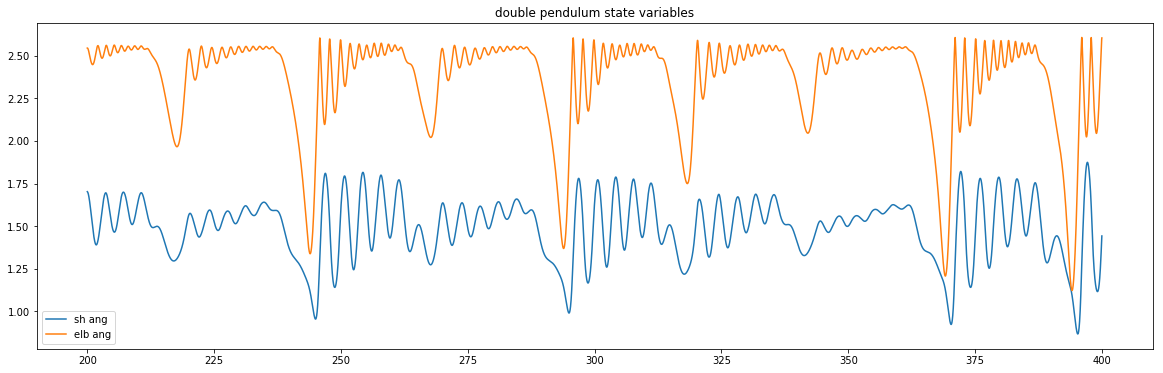

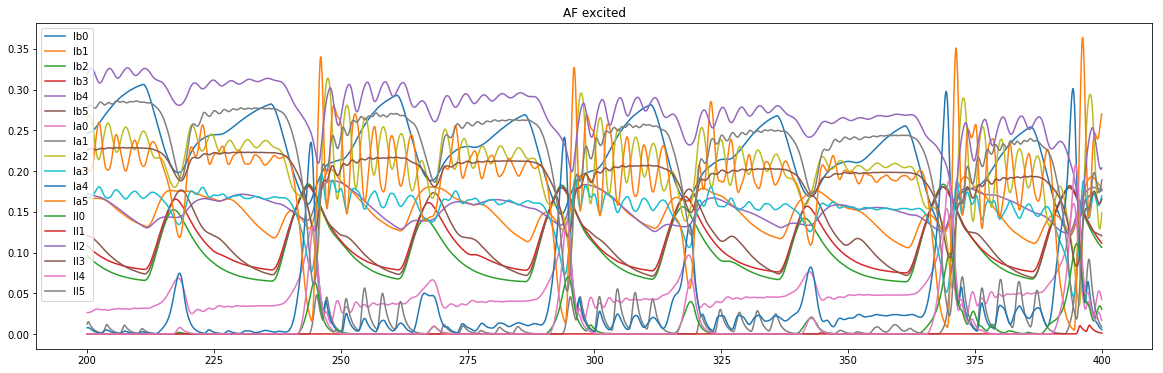

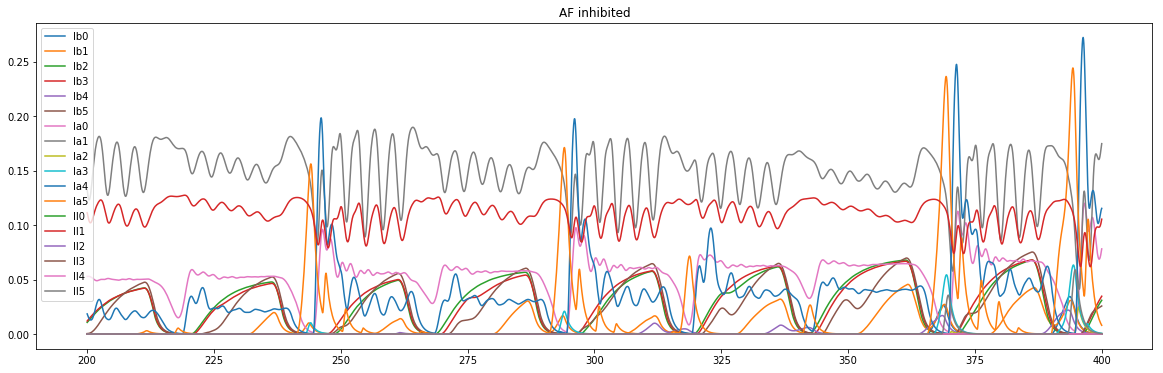

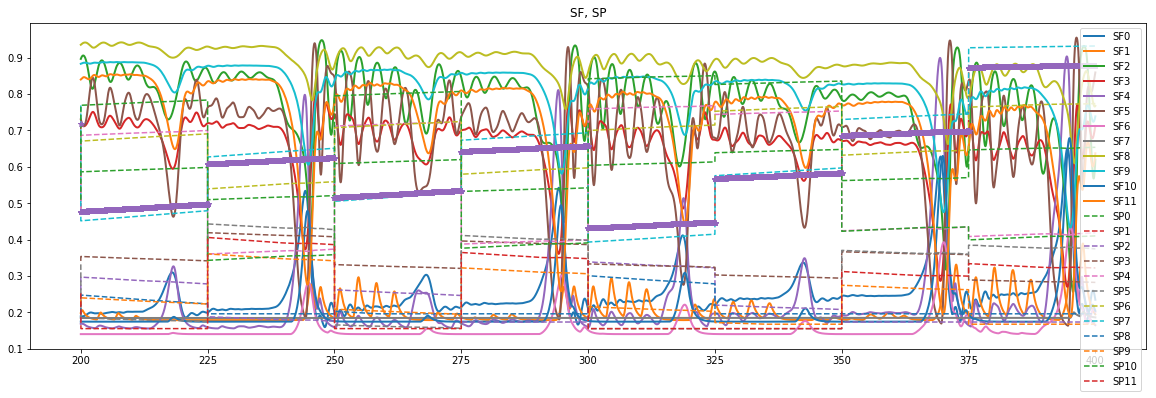

SF = 
[0.23451861 0.19450425 0.61903294 0.71200928 0.16464123 0.85900059
 0.20120289 0.18593608 0.76729315 0.73826688 0.20391819 0.63682702]
SP = 
[0.65334708 0.87772307 0.17328104 0.28212748 0.418632   0.3742038
 0.77347578 0.93167394 0.19585579 0.16728396 0.40985734 0.32181886]


In [17]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=2)
plt.plot(times, SP_data.transpose(), '--')
plt.plot(times, SP_data[1,:], '*')
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

In [10]:
AF_avgs

array([0.24, 0.1 , 0.64, 0.31, 0.43, 0.2 , 0.24, 0.11, 0.43, 0.29, 0.3 ,
       0.17])

In [71]:
# removing feedback to compare with Fink et al.
for uid in CE+CI:
    syn_list = net.syns[uid]
    for syn in syn_list:
        if syn.preID in AF:
            #syn.w = 0.
            syn.alpha = 1.
            syn.normalize = False